# <center>**Report IMA205 : Classification de mélanomes**<center>

##### <center> **Author : Guez Eliot**<center>



---

## <center> **Introduction**</center>

Le but de ce projet est de classer des images dermoscopiques de lésions cutanées parmi huit classes diagnostiques différentes :

1. Mélanome
2. Nævus mélanocytaire
3. Carcinome basocellulaire
4. Kératose actinique
5. Kératose bénigne
6. Dermatofibrome
7. Lésion vasculaire
8. Carcinome épidermoïde

Nous allons donc utiliser un dataset de 18 000 images déjà classifiées et 7000 images non classifiées de test pour entrainer un modèle de classification.

---

#### Le plan pour traité le problème sera donc le suivant

1. Tout d'abord, nous allons commencer par segmenter les images. Pour cela, nous allons essayer d'implémenter le papier Automated melanoma recognition
https://ieeexplore.ieee.org/document/918473 publié en 2001 par H. Ganster, P. Pinz, et R. Rohrer. On va appliquer des algorithmes de Preprocessing sur les images, puis on va calculer les masques, et enfin on appliquera des algorithmes de postprocessing pour avoir les masques finals. 

2. Ensuite, nous allons chercher à extraire des features des images segmentées. Pour cela, nous allons suivre la règle A,B,C,D. C'est-à-dire que nous allons extraire des features relatives à l'asymétrie, les bords, les couleurs et les dimensions des images segmentées.    

3. Nous utiliserons alors un modèle de classification pour classer les images segmentées. Pour cela, nous allons tenter plusieurs approches, SVM, Random Forest. 
4. Enfin, on essaiera d'implémenter un CNN qui prendra en entrée uniquement les images prétraités et qui seront donc utilisés pour la classification.  
---


## <center> **Partie I : Preprocessing**<center>


On va tout d'abord importer toute les bibliothèques nécessaires au fonctionnement des premiers algorithmes.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os 
import random
import pandas as pd
import cv2
from imageio.v3 import imread
from PIL import Image
from scipy.interpolate import griddata
from sklearn.cluster import KMeans
from skimage import io
from skimage import measure, morphology
import glob

On importe les données associées aux images

In [2]:
import glob
Working_directory= "C:\\Users\\eliot\\challenge\\eguez-22@gpu5"

images_train = glob.glob(Working_directory + '/Train/train/*.jpg')
segmentation_train = glob.glob(Working_directory + '/Train/train/*.png')
images_test = glob.glob(Working_directory + '/Test/test/*.jpg')
segmentation_test = glob.glob(Working_directory + '/Test/test/*.png')

print(len(images_train))
print(len(segmentation_train))
print(len(images_test))
print(len(segmentation_test))


18998
1945
6333
648


On va maintenant afficher quelques images pour voir quel problème on risque de rencontrer lors de la segmentation. 

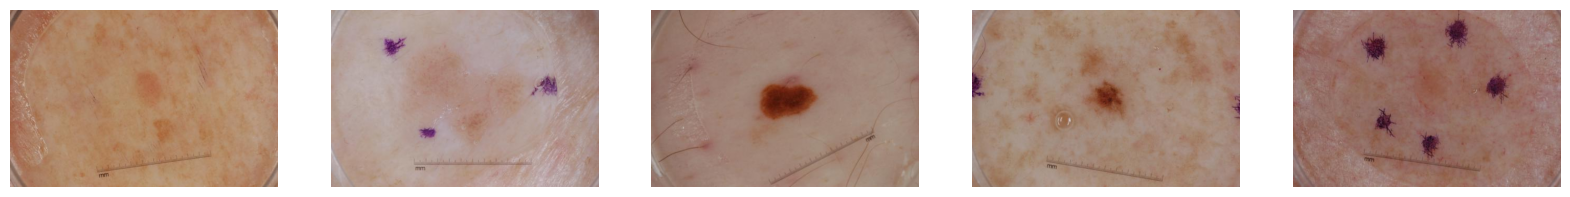

In [5]:
k = 5
k2 = 1300
fig, ax = plt.subplots(1, k, figsize=(20, 20))
for i in range(0, k):
    ax[i].imshow(imread(images_train[k2 +i]))
    ax[i].axis('off')

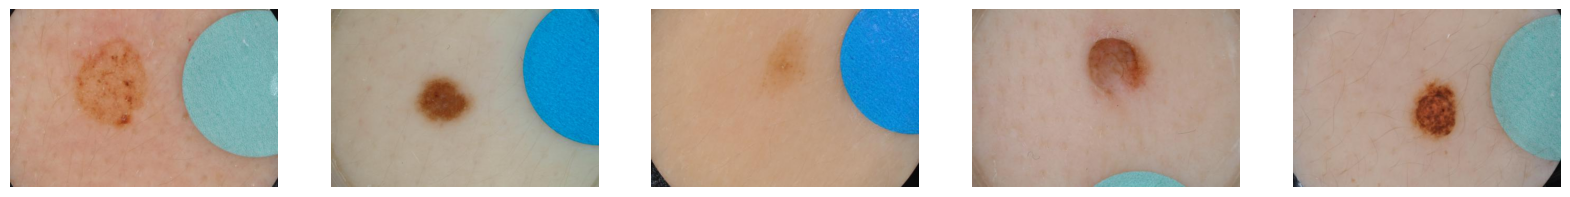

In [6]:
k = 5
k2 = 500
fig, ax = plt.subplots(1, k, figsize=(20, 20))
for i in range(0, k):
    ax[i].imshow(imread(images_train[k2 +i]))
    ax[i].axis('off')

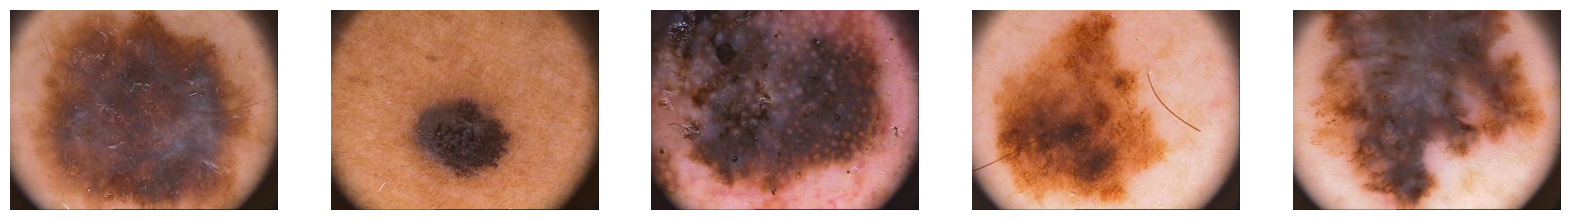

In [7]:
k = 5
k2 = 200
fig, ax = plt.subplots(1, k, figsize=(20, 20))
for i in range(0, k):
    ax[i].imshow(imread(images_train[k2 +i]))
    ax[i].axis('off')

On remarque que les images ont plusieurs défauts: Des poils sont présents et peuvent se mêler à la lésion la rendant plus difficile à segmenter. On remarque la présence de coin noir autours des images et des pansements ou patchs sont parfois présents sur certaines images. Nous essaierons donc de supprimer ces défauts avant de segmenter les images.

---
####  **A. Suppression des poils**
---


Pour supprimer les poils, on va utiliser l'algorithme dullrazor qui est mentionné dans plusieurs articles dont *Computerized analysis of pigmented skin lesions: A review* écrit par Konstantin Korotkov, Rafael Garcia. Pour réaliser cette opération, on utilise des opérations morphologiques. On utilise un filtre black Hat pour faire ressortir les zones sombres puis on applique un flou gaussien pour réduire le bruit et les détails fins, enfin on fait de l'inpainting sur les zones à retirer. Cette algorithme permet de retirer les poils mais aussi certaines traces de règles présentes dans plusieurs images. 

L'algorithme ci-dessous est tiré de la page github suivante : https://github.com/BlueDokk/Dullrazor-algorithm/blob/main/dullrazor.py

Mais il a été légèrement modifié pour être adapté aux données disponibles et à mon projet.  

In [3]:
def dullrazor(image):
    """
    Remove hair from an image using morphological operations
    """
    #DULL RAZOR (REMOVE HAIR)
    img = cv2.imread(image, cv2.IMREAD_COLOR)
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

    return dst

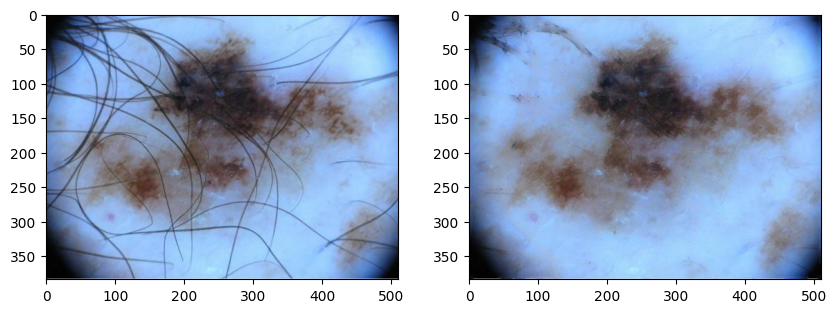

In [9]:
k  = 50
image = dullrazor(images_train[k])
# On veut afficher les images prétraitées et les images de bases en même temps pour voir l'effet du filtre
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(imread(images_train[k]))
ax[1].imshow(image)

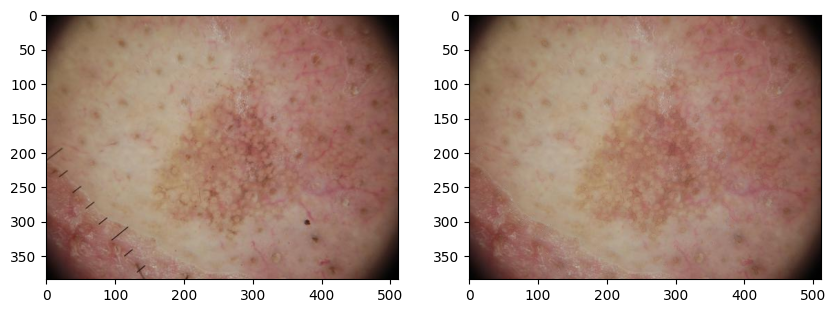

In [10]:
k  = 723
image = dullrazor(images_train[k])
# On veut afficher les images prétraitées et les images de bases en même temps pour voir l'effet du filtre
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(imread(images_train[k]))
ax[1].imshow(image)

Comme on peut le voir ci-dessus, cette algoritme est très bon et permet de bien supprimer les poils et les traits de mesures. 

---
####  **B. Suppression des pansements**
---

On va essayer de supprimer les pansements sur les images. Seulement le problème est beaucoup plus complexe que prévu puisque les fonctions connus comme les transformées de Hough fonctionne uniquement si l'ensemble du cercle est contenu dans l'image seulement comme on le voit sur la photo ci-dessus, les pansements sont pour leur plus grande partie aux extrémités de l'image donc ces cercles sont beaucoup plus difficiles à segmenter.  

La stratégie pour les trouver serait donc de prendre des points en dehors de l'image et de calculer si une forme de cercle dans l'image serait obtenu à partir de cela on prendrait alors les points de l'image appartenant au cercle et on les remplacerait avec de l'inpainting. Cependant, cette méthode me parait très complexe et c'est pourquoi je vais essayer d'implémenter une autre méthode à base de Kmeans et d'opération morphologique de base qu'on va essayer de récuperer le masque du pansement.
L'idée est d'appliquer un kmeans pour récupérer plusieurs formes contenues dans l'image.

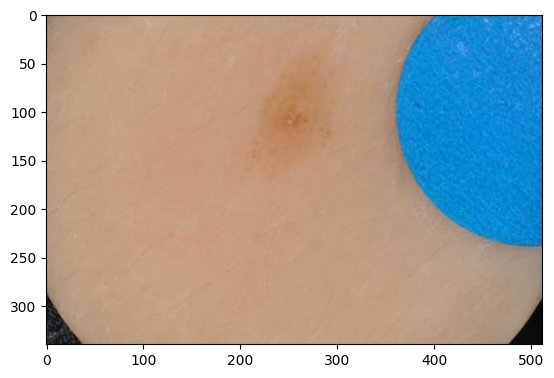

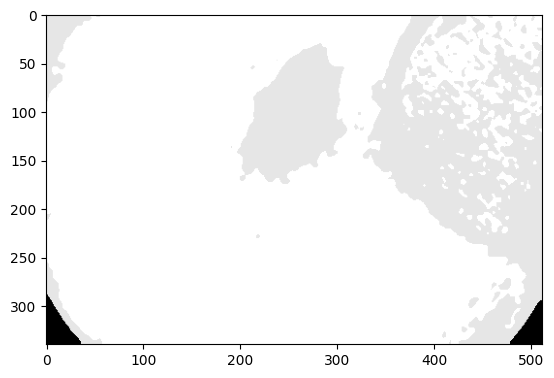

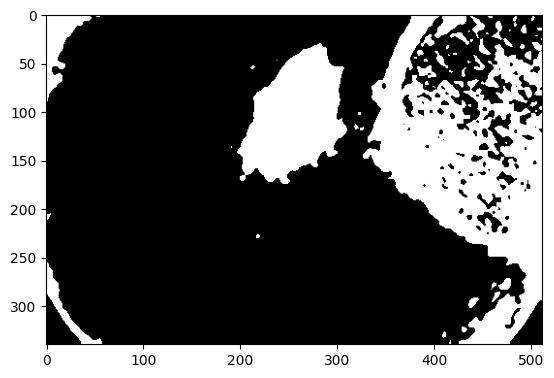

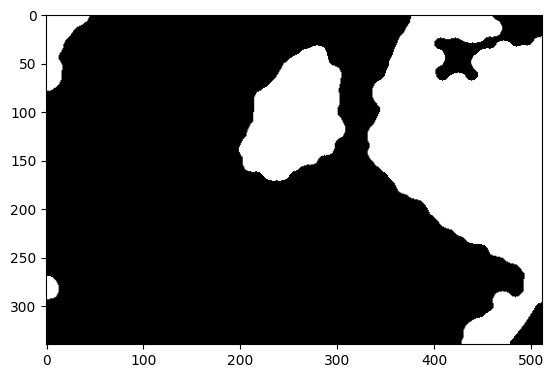

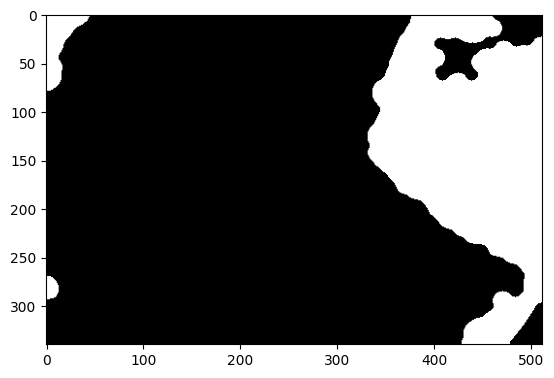

In [11]:
from sklearn import cluster

image = cv2.imread(images_train[502])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
h, w = image.shape[:2]

# On convertit en niveau de gris de 0 à 1
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY).astype(np.float32)/255

# On applique un filtre gaussien 
gray_blur = cv2.GaussianBlur(gray, (0,0), sigmaX=2, sigmaY=2)


image_1d = gray_blur.reshape(h*w,1)

# On applique un Kmeans clustering pour trouver les clusters de niveau de gris
num_clusters = 3
kmeans_cluster = cluster.KMeans(n_clusters=int(num_clusters), n_init=10)
kmeans_cluster.fit(image_1d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

# on remet dans le même format que l'image originale
newimage = cluster_centers[cluster_labels].reshape(h, w)*255.0
newimage = newimage.astype('uint8')

plt.imshow(newimage, cmap='gray')
plt.show()

# On applique un threshold pour garder uniquement, les valeurs de niveau de gris médianes. 

lower = (75)
upper = (150)
thresh = cv2.inRange(newimage, lower, upper)
plt.imshow(thresh, cmap='gray')
plt.show()

# On améliore le résultat en appliquant des opérations morphologiques
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(thresh, cmap='gray')
plt.show()

# on ne garade que les contours qui sont proches du bord
border_distance = 10
border_contours = []

for contour in contours:
    for point in contour:
        if point[0][0] < border_distance or point[0][0] > w - border_distance or point[0][1] < border_distance or point[0][1] > h - border_distance:
            border_contours.append(contour)
            break

mask = np.zeros((h, w), dtype=np.uint8)

# On dessine les contours sur le masque
cv2.drawContours(mask, border_contours, -1, (255), thickness=cv2.FILLED)
plt.imshow(mask, cmap='gray')
plt.show()


Le premier choix pour implémenter le code précédent était le format de couleur de l'image qu'on allait prendre avant de chercher à obtenir le masque. 
On observe qu'on a les meilleurs résultats pour une image RGB donc on va conserver cette base des couleurs pour la segmentation du pansement.

On remarque également qu'on détoure très souvent la lésion avec le Kmeans et on ne veut pas inpaint la lésion donc on va essayer de récupérer uniquement les zones qui sont sur les bords de l'image puisqu'on observe que généralement les pansements cotoient la bordure de l'image tandis que les lésions sont plus au centre. On voit sur la dernière image ci-dessus qu'on a donc supprimé la lésion du masque. Il ne reste plus qu'à inpaint ces pansements pour les effacer de l'image. 

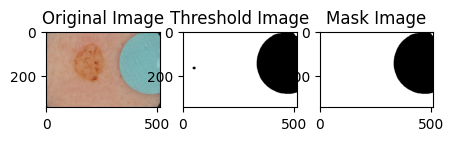

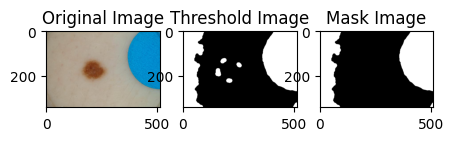

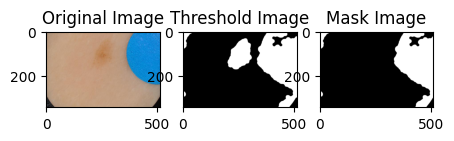

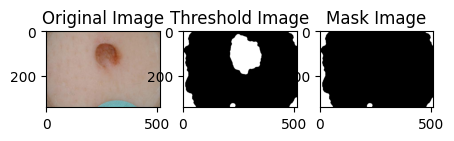

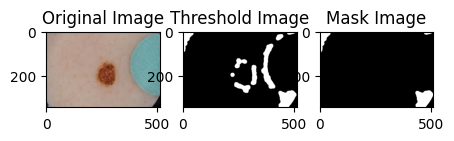

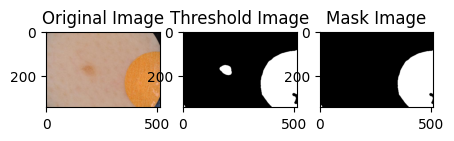

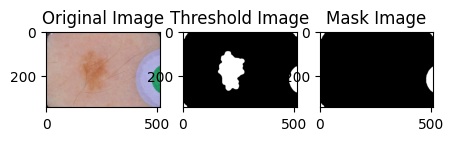

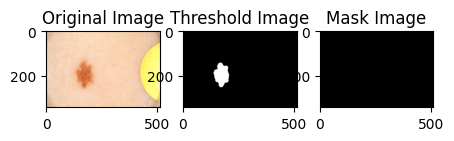

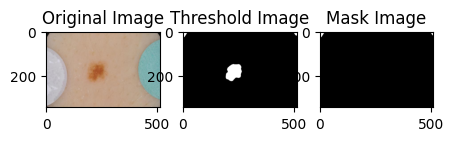

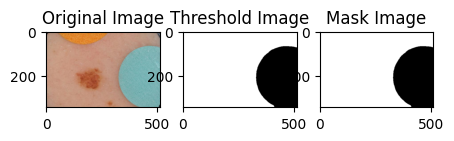

In [12]:
def remove_bandage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]

    # On convertit en niveau de gris de 0 à 1 et on applique un filtre gaussien
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY).astype(np.float32)/255
    gray_blur = cv2.GaussianBlur(gray, (0,0), sigmaX=2, sigmaY=2)


    image_1d = gray_blur.reshape(h*w,1)

    # on applique un Kmeans
    num_clusters = 3
    kmeans_cluster = cluster.KMeans(n_clusters=int(num_clusters), n_init=10)
    kmeans_cluster.fit(image_1d)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_

    # On remet les images dans le bon format
    newimage = cluster_centers[cluster_labels].reshape(h, w)*255.0
    newimage = newimage.astype('uint8')

    # On applique un threshold
    lower = (75)
    upper = (150)
    thresh = cv2.inRange(newimage, lower, upper)

    # On améliore le résultat avec des opérations morphologiques
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # On ne garde que les contours proches du bord
    border_distance = 10
    border_contours = []

    for contour in contours:
        for point in contour:
            if point[0][0] < border_distance or point[0][0] > w - border_distance or point[0][1] < border_distance or point[0][1] > h - border_distance:
                border_contours.append(contour)
                break


    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(mask, border_contours, -1, (255), thickness=cv2.FILLED)

    # Affichage des résultats
    plt.figure(figsize=(5, 5))

    # Affichage de l'image originale
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    # Affichage de l'image thresholdée
    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title('Threshold Image')

    # Affichage du masque
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask Image')

    plt.show()

    return mask


for k in range(500, 510):

    image = cv2.imread(images_train[k])
    mask = remove_bandage(image)

A cause du fonctionnement du Kmeans on remarque que les valeurs des pixels appartenant aux pansements peuvent soit être 0 soit 1. 
Par ailleurs, il arrive que les masques soit mauvais. On va donc appliquer les règles suivantes pour récupérer les bons masques seulement. 
1. Si la somme des pixels noirs et inférieur à la somme des pixels blancs, alors on inverse le masque.
2. Si la quantité de blanc est toujours trop élevé, au moins un quart de l'image, alors on met tout le masque à 0 pour être sûr de ne pas abimer les lésions. 
Après ces règles vérifiées seulement, on peut inpaint les pansements. 

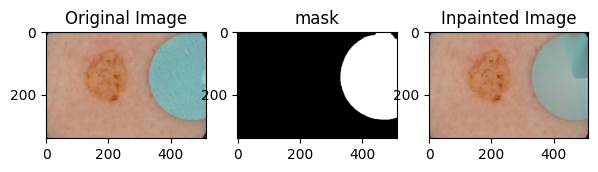

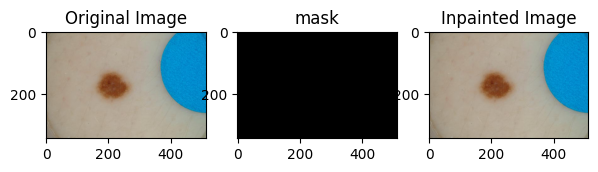

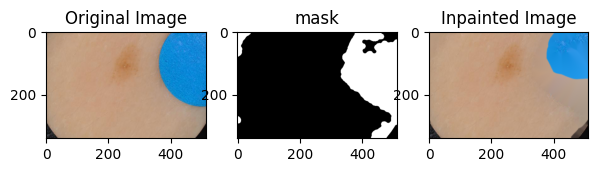

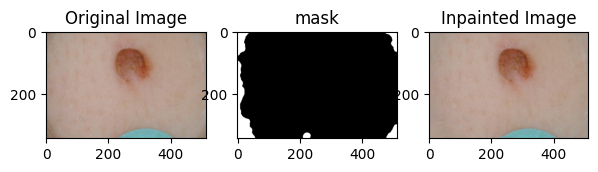

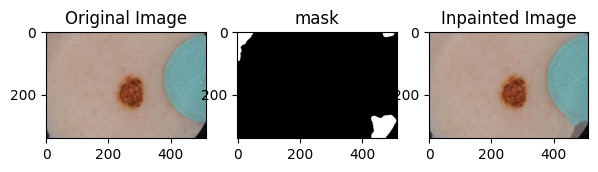

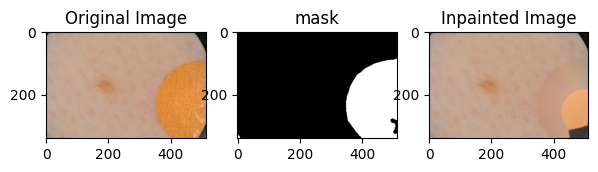

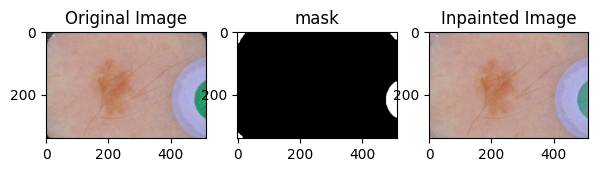

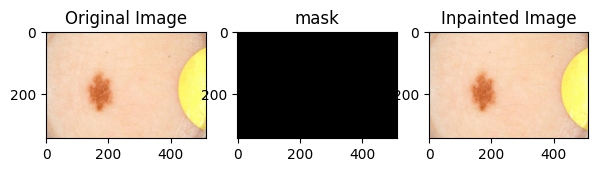

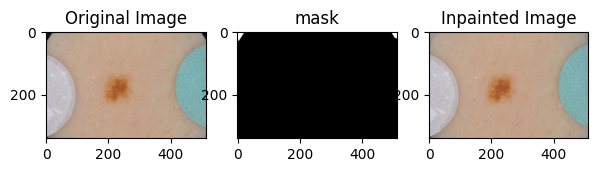

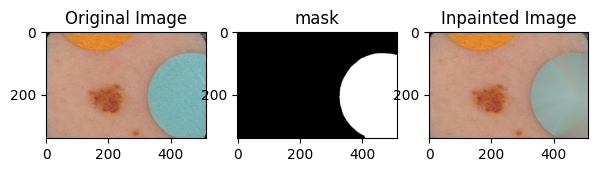

In [13]:
def remove_bandage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY).astype(np.float32)/255
    gray_blur = cv2.GaussianBlur(gray, (0,0), sigmaX=2, sigmaY=2)


    image_1d = gray_blur.reshape(h*w,1)
    num_clusters = 3
    kmeans_cluster = cluster.KMeans(n_clusters=int(num_clusters), n_init=10)
    kmeans_cluster.fit(image_1d)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_


    newimage = cluster_centers[cluster_labels].reshape(h, w)*255.0
    newimage = newimage.astype('uint8')

    lower = (75)
    upper = (150)
    thresh = cv2.inRange(newimage, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    border_distance = 10
    border_contours = []

    for contour in contours:
        for point in contour:
            if point[0][0] < border_distance or point[0][0] > w - border_distance or point[0][1] < border_distance or point[0][1] > h - border_distance:
                border_contours.append(contour)
                break


    mask = np.zeros((h, w), dtype=np.uint8)


    cv2.drawContours(mask, border_contours, -1, (255), thickness=cv2.FILLED)

    inverted_mask = cv2.bitwise_not(mask)

    if np.sum(mask == 255) > np.sum(inverted_mask == 255):
        mask = inverted_mask

    if np.sum(mask == 255) > h * w * 0.25: 
        mask = np.zeros((h, w), dtype=np.uint8)


    inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

    plt.figure(figsize=(7, 5))


    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')


    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('mask')

    plt.subplot(1, 3, 3)
    plt.imshow(inpainted_image)
    plt.title('Inpainted Image')

    plt.show()

    return mask

for k in range(500, 510):
    image = cv2.imread(images_train[k])
    mask = remove_bandage(image)

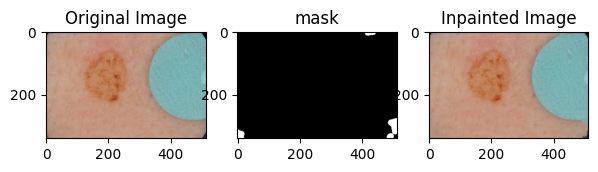

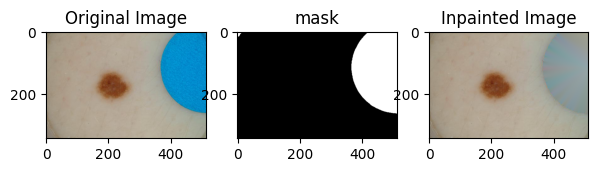

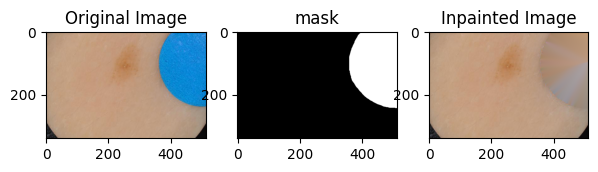

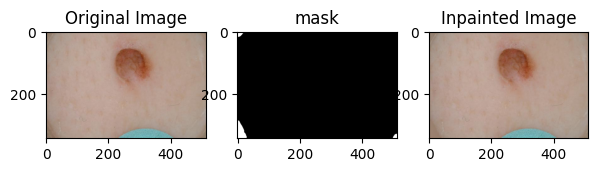

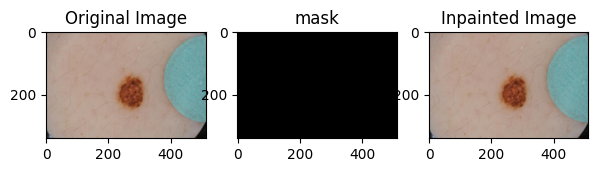

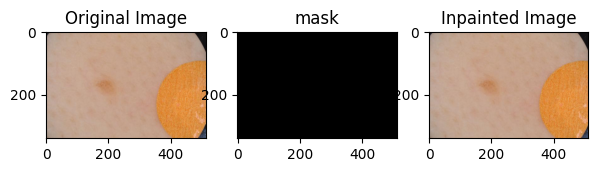

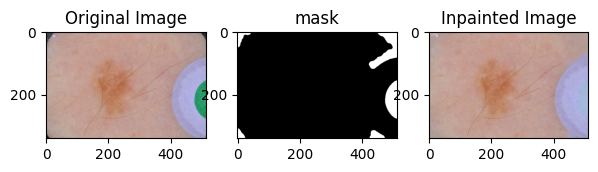

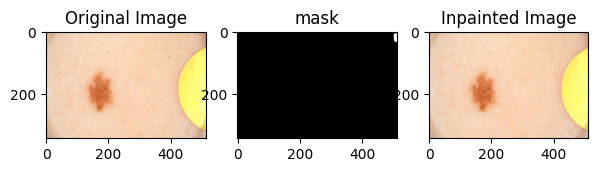

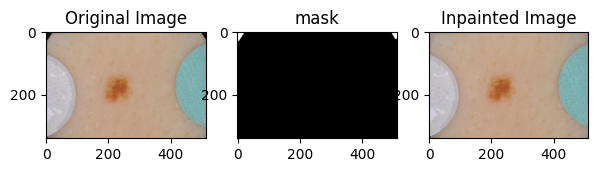

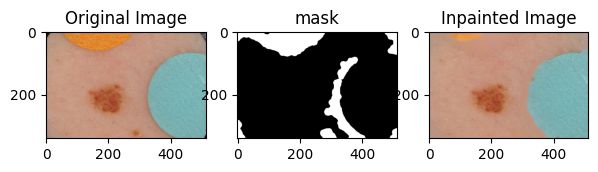

In [14]:
def remove_bandage(image):
    h, w = image.shape[:2]

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY).astype(np.float32)/255
    gray_blur = cv2.GaussianBlur(gray, (0,0), sigmaX=2, sigmaY=2)
    
    image_1d = gray_blur.reshape(h*w,1)

    num_clusters = 3
    kmeans_cluster = cluster.KMeans(n_clusters=int(num_clusters), n_init=10)
    kmeans_cluster.fit(image_1d)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_

    newimage = cluster_centers[cluster_labels].reshape(h, w)*255.0
    newimage = newimage.astype('uint8')

    lower = (75)
    upper = (150)
    thresh = cv2.inRange(newimage, lower, upper)


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  
    border_distance = 10
    border_contours = []

    for contour in contours:
        for point in contour:
            if point[0][0] < border_distance or point[0][0] > w - border_distance or point[0][1] < border_distance or point[0][1] > h - border_distance:
                border_contours.append(contour)
                break

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(mask, border_contours, -1, (255), thickness=cv2.FILLED)

    inverted_mask = cv2.bitwise_not(mask)

    if np.sum(mask == 255) > np.sum(inverted_mask == 255):
        mask = inverted_mask
    if np.sum(mask == 255) > h * w * 0.25: 
        mask = np.zeros((h, w), dtype=np.uint8)


    inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

    plt.figure(figsize=(7, 5))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')


    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('mask')
    inpainted_image = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
 
    plt.subplot(1, 3, 3)
    plt.imshow(inpainted_image)
    plt.title('Inpainted Image')

    plt.show()

    return mask

for k in range(500, 510):
    image = cv2.imread(images_train[k])
    mask = remove_bandage(image)

Les deux fonctions précédentes sont les mêmes à l'exception de la conversion en RGB pour la première fonction. On voit effectivement que la conversion en RGB améliore les résultats. Cependant, on remarque que même pour les images en RGB, il y a peu de d'images où les pansements sont correctement remplacés, et le masque donne rarement des résultats corrects, l'inpainting donné n'est pas très bon. 

C'est pourquoi, comme ce type d'image est minoritaire, nous ne garderons pas cette méthode pour le préprocessing. 

---
####  **C. Suppresion des coins noirs**
---

On obseve par exemple que pour les images 5 et 7, on a des coins noirs. Ces coins peuvent poser des problèmes pour la segmentation. On va donc tâcher également de les supprimer. 


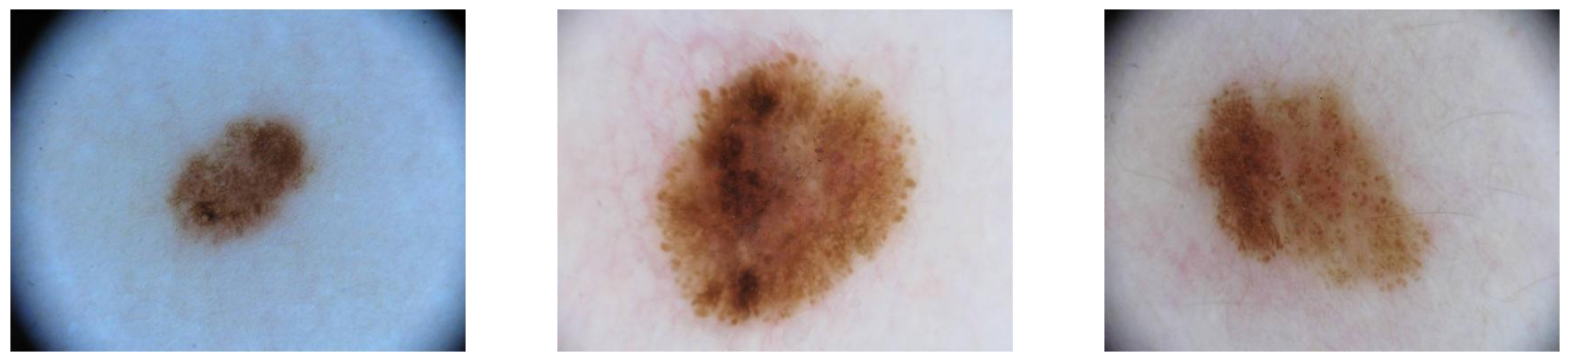

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
for i in range(0, 3):
    ax[i].imshow(imread(images_train[5 +i]))
    ax[i].axis('off')

Après avoir supprimé les poils de l'image, on va appliquer un threshold pour récupérer les parties très foncées de l'image. Puis on calcule le cercle le plus petit englobant le plus grand contour est calculé. On récupére ensuite le masque avec les coins noirs et on va essayer  de les remplacer.
En première approximations, on avait remplacé par la moyenne sur chaque channel des pixels de l'image. 

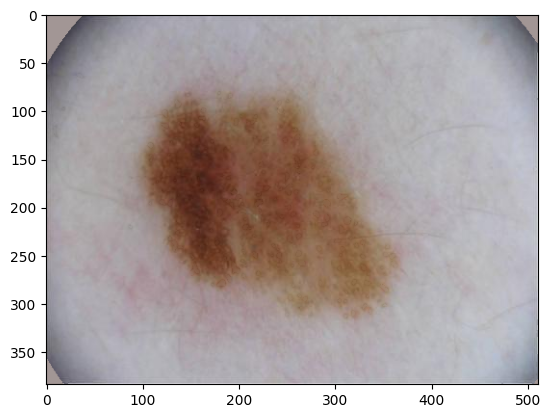

In [16]:
## première méthode : on donne là où le masque = 0 la valeur du pixel moyen de l'image

k = 7
image = dullrazor(images_train[k])

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, thresh_img = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contoursB = []
big_contour = []
this_max = 0
for i in contours:
    area = cv2.contourArea(i) #--- find the contour having biggest area ---
    if(area > this_max):
        this_max = area
        big_contour = i 
        contoursB.append(i)

(x,y), radius = cv2.minEnclosingCircle(np.asarray(big_contour))
center = (int(x), int(y))
radius = int(radius) - 2
this_contour = cv2.circle(np.ones(gray_image.shape), center, radius, (0,255,0), -1)
this_contour[this_contour == 1] = 255 
mask = Image.fromarray(this_contour)
mask = mask.convert('L')
# inverser le masque 
mask = np.array(mask)
mask = cv2.bitwise_not(mask)
mask = mask/255
plt.imshow(mask, cmap='gray')

#première méthode : on donne là où le masque = 0 la valeur du pixel moyen de l'image
interpol_v0 = image.copy()
moyenne_r = np.mean(image[:, :, 0])
moyenne_g = np.mean(image[:, :, 1])
moyenne_b = np.mean(image[:, :, 2])
# Set the pixels where the mask is 0 to the mean pixel value
interpol_v0[mask == 0] = [moyenne_r, moyenne_g, moyenne_b]
plt.imshow(interpol_v0)

On voit ici qu'on a bien supprimé les coins noirs de l'image mais le fait de les remplacer par la même valeur les rend possiblement plus facile à segmenter et peuvent empêcher la segmentation de la lésion. On va donc essayer de les remplacer par de l'inpainting.   
Ci-dessous, on utilise l'inpainting TELEA qui donne les meilleurs résultats. Pour le premier masque qu'on obtient via la méthode ci-dessous, les coins restent assez foncées car on inpaint uniquement sur la zone noir. Une méthode possible est donc de réduire la taille du cercle pour inpaint plus tôt et ainsi supprimer les coins noirs. 

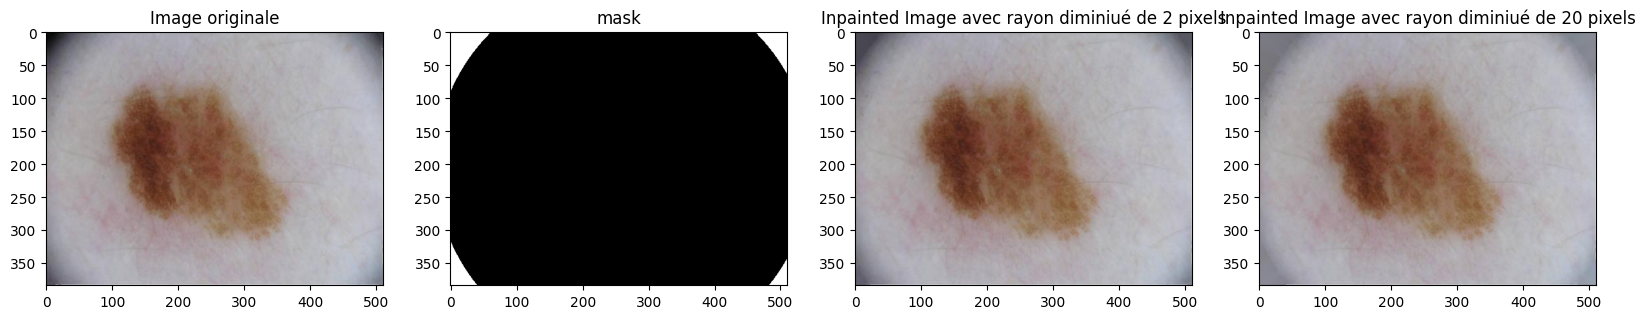

In [17]:
k = 7
image = dullrazor(images_train[k])

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, thresh_img = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contoursB = []
big_contour = []
this_max = 0
for i in contours:
    area = cv2.contourArea(i) #--- find the contour having biggest area ---
    if(area > this_max):
        this_max = area
        big_contour = i 
        contoursB.append(i)

(x,y), radius = cv2.minEnclosingCircle(np.asarray(big_contour))
center = (int(x), int(y))
radius = int(radius) - 2
this_contour = cv2.circle(np.ones(gray_image.shape), center, radius, (0,255,0), -1)
this_contour[this_contour == 1] = 255 
mask = Image.fromarray(this_contour)
mask = mask.convert('L') 
mask = np.array(mask)
mask = mask/255
mask = mask.astype(np.uint8)
# inpaint 
dst = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)


(x,y), radius = cv2.minEnclosingCircle(np.asarray(big_contour))
center = (int(x), int(y))
radius = int(radius) - 20
this_contour = cv2.circle(np.ones(gray_image.shape), center, radius, (0,255,0), -1)
this_contour[this_contour == 1] = 255 
mask = Image.fromarray(this_contour)
mask = mask.convert('L') 
mask = np.array(mask)
mask = mask/255
mask = mask.astype(np.uint8)
dst2 = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

# inpaint 
fig,ax = plt.subplots(1,4,figsize=(20,20))
ax[0].imshow(image)
ax[0].set_title('Image originale')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('mask')
ax[2].imshow(dst)
ax[2].set_title('Inpainted Image avec rayon diminiué de 2 pixels')
ax[3].imshow(dst2)
ax[3].set_title('Inpainted Image avec rayon diminiué de 20 pixels')
plt.show()


Les résultats sont beaucoup mieux avec cette méthode. On a bien supprimé les coins noirs et on a bien inpaint les zones noires. Pour simplifier plus tard le préprocessing, on va implémenter une fonction qui regroupe les opérations précédentes.

In [4]:
def dark_corners_removal(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh_img = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contoursB = []
    big_contour = []
    this_max = 0
    for i in contours:
        area = cv2.contourArea(i) #--- find the contour having biggest area ---
        if(area > this_max):
            this_max = area
            big_contour = i 
            contoursB.append(i)

    (x,y), radius = cv2.minEnclosingCircle(np.asarray(big_contour))
    center = (int(x), int(y))
    radius = int(radius) - 20
    this_contour = cv2.circle(np.ones(gray_image.shape), center, radius, (0,255,0), -1)
    this_contour[this_contour == 1] = 255 
    mask = Image.fromarray(this_contour)
    mask = mask.convert('L')
    # inverser le masque 
    mask = np.array(mask)
    mask = mask/255
    mask = mask.astype(np.uint8) 
    dst = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
    return dst

---
## <center> **Partie II : Segmentation des images**<center>

#### **A. Méthode à adopter pour obtenir les masques**
---

On va suivre le papier *Automated Melanoma recognition* écrit par H. Ganster, A. Pinz, et R. Rohrer publié en mars 2001. 

L'idée est la suivante : calculer plusieurs masques sur différents channels de couleurs sur l'image. Puis on va combiner ces masques selon certaines règles et les fusionner pour avoir le masque final. 

1. On utilise un threshold global ou adpatatif avec le channel bleu dans le modèle couleur rgb et le channel b dans le modèle couleur CIE-Lab.
2. On utilise ensuite un 3-D color clustering avcec les channels X,Y et Z du modèle couleur CIE-XYZ.
3. Enfin, on va récupérer les régions les plus grosses de chaque masques. 

Maintenant nous allons suivre les règles ci-dessous pour obtenir le masque final :

1. Les segmentations dont le masque des lésions croît sur les bordures de l'image sont rejétées
2. Les segmentations sans aucune région détectée sont rejetés
3. Les segmentations qui comprennent des fragments dans la bordure de l'image sont rejetées.    
4. La segmentation avec le plus petit masque est rejetée.
5. Les segmentations dont les aires de masques différent grandement des autres segmentations sont rejetées   
6. les segmentations restantes sont combinées pour former le masque final.


---
#### **B. Construction des différents masques**
---

Pour construire ces différents masques selon les règles énoncées précédemment. On a du choisir entre un threshold global ou un threshold local, ainsi que la méthode dont on choisit le meilleur threshold. Après divers tests et sur plusieurs images, les résultats semblait les plus proches des segmentations données pour un treshold global avec la méthode Otsu. 
On commence donc par récupérer les 3 formats de l'image et les canaux spécifiques, puis on appliquera les différents threshold.

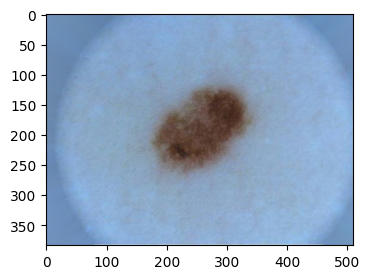

In [19]:
### On récupère l'image déjà préprocessed :
k = 5
image = dullrazor(images_train[k])
dst = dark_corners_removal(image)
image = dst
plt.figure(figsize=(5, 3))
plt.imshow(image)

(384, 511) (384, 511) (384, 511) (384, 511) (384, 511) (384, 511, 3)


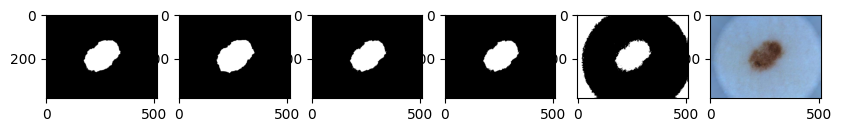

In [20]:
### Conversion dans les différents channels et modéles

# modèle RGB
r, g, b = cv2.split(image)

# Convertit dans le modèle Lab
lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
l, a, b_lab = cv2.split(lab)

# On convertit dans le modéle XYZ 
xyz = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)
x, y, z = cv2.split(xyz)



#### On applique les différents thresholds et on inverse les masques pour avoir la segmentation de la lésion
# On applique un threshold global sur le channel bleu du modèle rgb avec OTSU
_, b_thresh = cv2.threshold(b, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
b_thresh_inv = cv2.bitwise_not(b_thresh)

# On applique un threshold global sur le channel b du modèle LAB  avec OTSU
_, b_lab_thresh = cv2.threshold(b_lab, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
b_lab_thresh_inv = cv2.bitwise_not(b_lab_thresh)

# On applique un threshold global sur le channel X du modèle XYZ avec OTSU
_, x_thresh = cv2.threshold(x, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
x_thresh_inv = cv2.bitwise_not(x_thresh)

# On applique un threshold global sur le channel X du modèle XYZ avec OTSU
_, y_thresh = cv2.threshold(y, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
y_thresh_inv = cv2.bitwise_not(y_thresh)

# On applique un threshold global sur le channel X du modèle XYZ avec OTSU
_, z_thresh = cv2.threshold(z, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
z_thresh_inv = cv2.bitwise_not(z_thresh)



# print les tailles des masques et de l'image 
print(b_thresh_inv.shape,b_lab_thresh_inv.shape,x_thresh_inv.shape, y_thresh_inv.shape, z_thresh_inv.shape, image.shape  )

### Plot the masks 
fig, ax = plt.subplots(1, 6, figsize=(10,10))
ax[0].imshow(b_thresh_inv, cmap='gray')
ax[1].imshow(b_lab_thresh_inv, cmap='gray')
ax[2].imshow(x_thresh_inv, cmap='gray')
ax[3].imshow(y_thresh_inv, cmap='gray')
ax[4].imshow(z_thresh_inv, cmap='gray')
ax[5].imshow(image)

La fonction ci-dessous permet de prendre un masque et de garder uniquement la plus grande région seulement.

In [5]:
def keep_largest_area(mask):
    # On récupére les contours dans le masque
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # S'il n'y a pas de contours, on retourne le masque original
    if not contours:
        return mask

    # Sinon, on récupére le plus grand contour
    largest_contour = max(contours, key=cv2.contourArea)

    # On crée un nouveau masque pour dessiner le contour le plus grand 
    largest_area_mask = np.zeros_like(mask)

    # On dessine le plus grand contour sur le nouveau masque
    cv2.drawContours(largest_area_mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return largest_area_mask

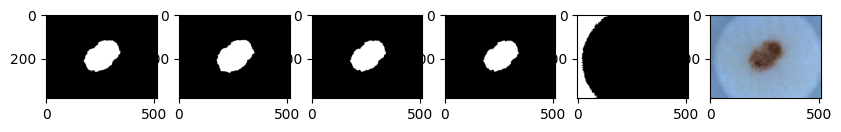

In [22]:
# keep the largest area to each mask 
b_thresh_inv = keep_largest_area(b_thresh_inv)
b_lab_thresh_inv = keep_largest_area(b_lab_thresh_inv)
x_thresh_inv = keep_largest_area(x_thresh_inv)
y_thresh_inv = keep_largest_area(y_thresh_inv)
z_thresh_inv = keep_largest_area(z_thresh_inv)

### Plot the masks 
fig, ax = plt.subplots(1, 6, figsize=(10,10))
ax[0].imshow(b_thresh_inv, cmap='gray')
ax[1].imshow(b_lab_thresh_inv, cmap='gray')
ax[2].imshow(x_thresh_inv, cmap='gray')
ax[3].imshow(y_thresh_inv, cmap='gray')
ax[4].imshow(z_thresh_inv, cmap='gray')
ax[5].imshow(image)

Ci-dessus, on a utilisé des threshold pour tout les channels et non pas des kmeans pour le clustering. Pour voir si les résultats étaient meilleur que les thresholds. 
On fait des Kmeans ci-dessous mais plusieurs problèmes se posent:
Les coins noirs même après l'inpainting peuvent parfois être considéré comme un plus grosse classe lorsque les lésions sont petites et il n'arrive donc pas à récupérer la lésion, et parfois et indépendamment de notre volonté, la lésion est considéré comme noire ou blanche sur le masque.  On va donc garder le thresholding globale plutôt que le kmeans pour la segmentation.

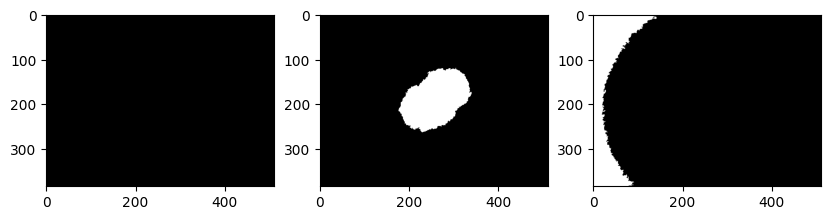

In [23]:
# apply kmeans clustering to the x,y,z channel of the CIE-XYZ color model
# Convert the image from RGB to XYZ color space
xyz = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)
x, y, z = cv2.split(xyz)

x = x.reshape(image.shape[:2])
y = y.reshape(image.shape[:2])
z = z.reshape(image.shape[:2])

# Apply KMEANS
kmeans_X = KMeans(n_clusters=2, n_init= 'auto').fit(x.reshape(-1,1))
kmeans_Y = KMeans(n_clusters=2, n_init= 'auto').fit(y.reshape(-1,1))
kmeans_Z = KMeans(n_clusters=2,n_init= 'auto').fit(z.reshape(-1,1))

segmented_X = kmeans_X.predict(x.reshape(-1,1))
segmented_Y = kmeans_Y.predict(y.reshape(-1,1))
segmented_Z = kmeans_Z.predict(z.reshape(-1,1))

clustered_image_x = segmented_X.reshape(image.shape[:2])
clustered_image_y = segmented_Y.reshape(image.shape[:2])
clustered_image_z = segmented_Z.reshape(image.shape[:2])

# on garde la plus grande zone de clustered_image_x, clustered_image_y, clustered_image_z 
clustered_image_x = clustered_image_x.astype('uint8')
clustered_image_y = clustered_image_y.astype('uint8')
clustered_image_z = clustered_image_z.astype('uint8')

clustered_image_x = keep_largest_area(clustered_image_x)
clustered_image_y = keep_largest_area(clustered_image_y)
clustered_image_z = keep_largest_area(clustered_image_z)


fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(clustered_image_x, cmap='gray')
ax[1].imshow(clustered_image_y, cmap='gray')
ax[2].imshow(clustered_image_z, cmap='gray')

On va construire une fonction qui prend donc l'image et qui renvoie les 5 masques.

In [6]:
def cinq_masques(image) :

    # convertir l'image dans les bons espaces de couleur
    r, g, b = cv2.split(image)

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b_lab = cv2.split(lab)

    xyz = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)
    x, y, z = cv2.split(xyz)

    # masque 1 rgb bleu
    _, b_thresh = cv2.threshold(b, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    b_thresh_inv = cv2.bitwise_not(b_thresh)
    # masque 2 lab b
    _, b_lab_thresh = cv2.threshold(b_lab, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    b_lab_thresh_inv = cv2.bitwise_not(b_lab_thresh)

    # masque 3 xyz x
    _, x_thresh = cv2.threshold(x, 100, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    x_thresh_inv = cv2.bitwise_not(x_thresh)
    # masque 4 xyz y
    _, y_thresh = cv2.threshold(y, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    y_thresh_inv = cv2.bitwise_not(y_thresh)
    # masque 5 xyz z
    _, z_thresh = cv2.threshold(z, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    z_thresh_inv = cv2.bitwise_not(z_thresh)
    

    # garde le plus grand contour de l'image
    b_thresh_inv = keep_largest_area(b_thresh_inv)
    b_lab_thresh_inv = keep_largest_area(b_lab_thresh_inv)
    x_thresh_inv = keep_largest_area(x_thresh_inv)
    y_thresh_inv = keep_largest_area(y_thresh_inv)
    z_thresh_inv = keep_largest_area(z_thresh_inv)

    return b_thresh_inv, b_lab_thresh_inv, x_thresh_inv, y_thresh_inv, z_thresh_inv

--- 
#### **C. Postprocessing des masques**
---

Comme décrit précédemment, on va créer une fonction qui prend en entrée les différents masques et qui définit les règles pour obtenir le masque final. 

On rappelle les règles à respecter pour obtenir le masque final :
1. Les segmentations dont le masque des lésions croît sur les bordures de l'image sont rejétées
2. Les segmentations sans aucune région détectée sont rejetés
3. Les segmentations qui comprennent des fragments dans la bordure de l'image sont rejetées.    
4. La segmentation avec le plus petit masque est rejetée.
5. Les segmentations dont les aires de masques différent grandement des autres segmentations sont rejetées   
6. les segmentations restantes sont combinées pour former le masque final.

Tout d'abord, cette fonction va supprimer les masques qui ont des points communs avec le bord de l'image. Cela peut-être problématique lorsque la lésion est très grande et qu'elle touche les coins de l'image mais on traitera ce problème plus tard.  
Par ailleurs, cette fonction va également retirer les masques qui n'ont rien détectés. Les autres règles étant dépendantes en partie de cette étape, on va séparer en deux fonctions. 

In [7]:
def check_mask(mask):
    # Règle 1: Rejeter les masques qui touchent la bordure de l'image 
    if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
        return False
    # Règle 2: Rejeter les masques qui n'ont détecté aucune région
    if not np.any(mask):
        return False    
    return True

Après avoir récupéré les masques, on les passe dans la fonction précédente pour ne garder que les masques qui respectent le règles 1, 2 et 3.  A partir des masques restants, on va supprimer celui qui a le moins de pixels, si tentait qu'il y ait plusieurs masques restants après le passage des règles précédentes. Puis on calcule l'aire moyenne de chaque masque. Si un masque a une aire qui diffère de plus de 50% de l'aire moyenne, on le supprime. Enfin, on combine les masques restants pour obtenir le masque final.

[4146810, 4452300, 3956580, 3881865, 5304765]
4185230.0
[True, True, True, False, False]


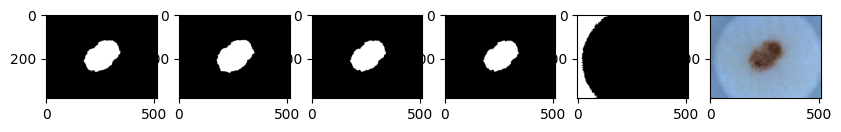

In [26]:
# On initialise les bons et les mauvais masques
masks = [b_thresh_inv, b_lab_thresh_inv, x_thresh_inv, y_thresh_inv, z_thresh_inv]
valid_masks = [check_mask(mask) for mask in masks]

# Initialisation des aires des masques 
areas = [np.sum(mask) for mask in masks]
min_area = min(areas)

# Règle 3: On rejette le plus petit masque si au moins deux masques sont valides
if sum(valid_masks) > 1:
    for i in range(len(valid_masks)):
        if valid_masks[i] and areas[i] == min_area:
            valid_masks[i] = False
            break

mean_area = np.mean([areas[i] for i in range(len(areas)) if valid_masks[i]])  # moyenne des aires des masques encore valides
max_area_diff = 0.5 * mean_area                                               

print(areas)
print(mean_area)

# Règle 5: on rejete les masques dont l'aire diffère trop des autres masques
for i in range(len(valid_masks)):
    if valid_masks[i] and not (mean_area-max_area_diff<= areas[i]<= max_area_diff + mean_area):
        print(mean_area-max_area_diff , ' ' ,  areas[i] ,  ' ' ,  max_area_diff + mean_area)
        valid_masks[i] = False

print(valid_masks)

fig, ax = plt.subplots(1, 6, figsize=(10,10))
ax[0].imshow(b_thresh_inv, cmap='gray')
ax[1].imshow(b_lab_thresh_inv, cmap='gray')
ax[2].imshow(x_thresh_inv, cmap='gray')
ax[3].imshow(y_thresh_inv, cmap='gray')
ax[4].imshow(z_thresh_inv, cmap='gray')
ax[5].imshow(image)

Il ne suffit plus maintenant qu'à fusionner les masques. La première méthode à laquel on peut penser est de vérifier si un pixel est dans plus de la moitié des masques restants et à le garder si c'est le cas. Cependant, cette méthode est compliquée puisqu'elle suppose qu'on connaisse le nombre de masques restants après le postprocessing. Cette donnée est très variable. On va donc simplement faire un OR : Si un pixel est dans un des masques restants alors il est dans le masque final. La fonction suivante permet d'implémenter cela.

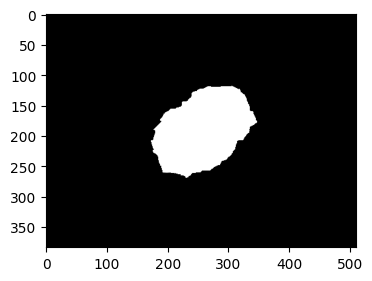

In [27]:
# Initialisation
final_mask = np.zeros_like(b_thresh_inv, dtype=bool)

# on combine les masques valdies
for i in range(len(valid_masks)):
    if valid_masks[i]:
        final_mask = np.logical_or(final_mask, masks[i])

# afficher le masque final
plt.figure(figsize=(4, 4))
plt.imshow(final_mask, cmap='gray')  

On implémente donc ci-dessous une fonction qui regroupe toutes les étapes précédentes, prenant donc en entrée une image et renvoyant le masque final.

On remarque que certaines fois les masques arrivent à trouver la lésion cependant celle-ci touche légérement la bordure de l'image. Nénamoins, modifier le programme précédent peut affecter tout les autres masques et avoir des conséquences sur la segmentation. On va donc choisir de prendre pour masque final le masque obtenu par le thresholding global sur le channel bleu de l'image, si jamais on ne trouve aucune segmentation. Et pour ne pas avoir d'images avec des masques vides, on va mettre le masque à 1 si jamais même après cela on ne trouve aucune segmentation.

In [26]:
def preprocess_image(ima):

    image = dullrazor(ima)
    try:
        image = dark_corners_removal(image)
    except:
        print('error')
    b_thresh_inv, b_lab_thresh_inv, x_thresh_inv, y_thresh_inv, z_thresh_inv = cinq_masques(image)
    
    # calcul du masque suivant les règles
    masks = [b_thresh_inv, b_lab_thresh_inv, x_thresh_inv, y_thresh_inv, z_thresh_inv]
    valid_masks = [check_mask(mask) for mask in masks]
    areas = [np.sum(mask) for mask in masks]
    min_area = min(areas)

    if sum(valid_masks) > 1:
        for i in range(len(valid_masks)):
            if valid_masks[i] and areas[i] == min_area:
                valid_masks[i] = False
                break
    
    if sum(valid_masks) != 0:
        mean_area = np.mean([areas[i] for i in range(len(areas)) if valid_masks[i]])
        max_area_diff = 0.5 * mean_area
    else: 
        mean_area = 0
        max_area_diff= 0
    
    for i in range(len(valid_masks)):
        if valid_masks[i] and not (mean_area-max_area_diff<= areas[i]<= max_area_diff + mean_area):
            valid_masks[i] = False
    # concaténation des masques valides
    final_mask = np.zeros_like(b_thresh_inv, dtype=bool)
    for i in range(len(valid_masks)):
        if valid_masks[i]:
            final_mask = np.logical_or(final_mask, masks[i])
    if np.sum(final_mask)==0:
        if np.sum(b_thresh_inv)!=0:
            return image, b_thresh_inv
        else: 
            print('no mask found')
            return image, np.ones_like(b_thresh_inv)

    return image, final_mask

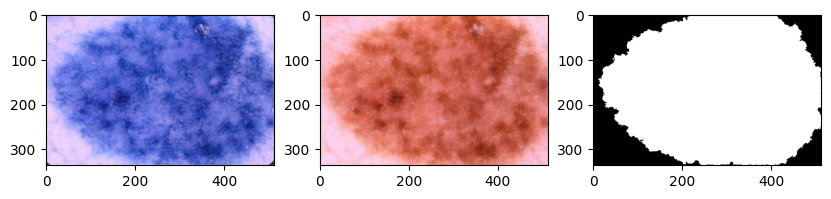

In [27]:
ima = cv2.imread('Train/train/ISIC_0000207.jpg')
ima_processed, mask = preprocess_image('Train/train/ISIC_0000207.jpg')
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(ima)
ax[1].imshow(ima_processed)
ax[2].imshow(mask, cmap='gray')

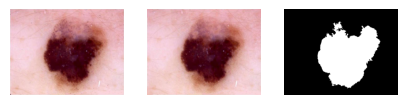

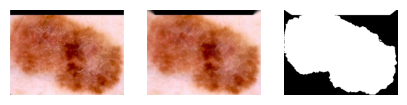

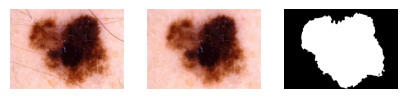

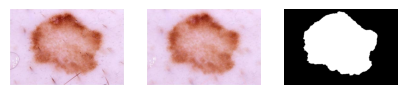

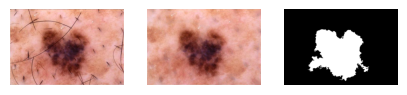

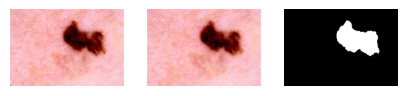

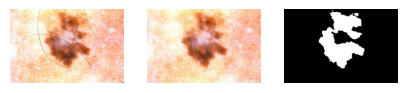

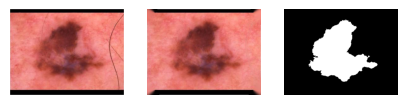

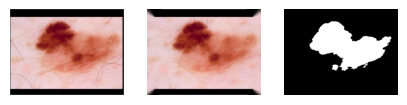

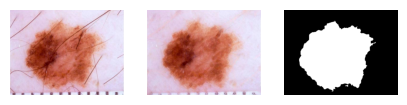

In [28]:
### On teste la fonction preprocess_image sur quelques images
for k in range(110, 120):
    fig, ax = plt.subplots(1, 3, figsize=(5,5))
    image = imread(images_train[k])
    image_processed, mask = preprocess_image(images_train[k])
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[1].imshow(image_processed)
    ax[1].axis('off')
    ax[2].imshow(mask, cmap='gray')
    ax[2].axis('off')
    plt.show()

---
#### **D. Efficacité de la segmentation**
---

Il ne reste plus donc qu'à quantifier l'efficacité de la segmentation.

Comme métrique de comparaison des masques, on va utiliser la méthode dice_coefficients qui est une méthode très utilisée pour comparer des masques et qu'on avait utilisé spécifiquement pour la segmentation de certaines parties du coeur dans un projet précédent. 

In [43]:
def dice_coeff(inputs, target): 
    inputs = inputs > 0
    target = target > 0

    intersection = inputs * target
    dice = (2. * intersection.sum()) / (inputs.sum() + target.sum())
    
    # On s'assure que le dice soit entre 0 et 1
    dice = np.clip(dice, 0, 1)
    
    return dice

On va calculer la valeur moyenne, la médiane ainsi que l'histogramme du dice. 

100%|██████████| 18998/18998 [08:58<00:00, 35.26it/s]   


0.8788461025271529
0.7476243734572291


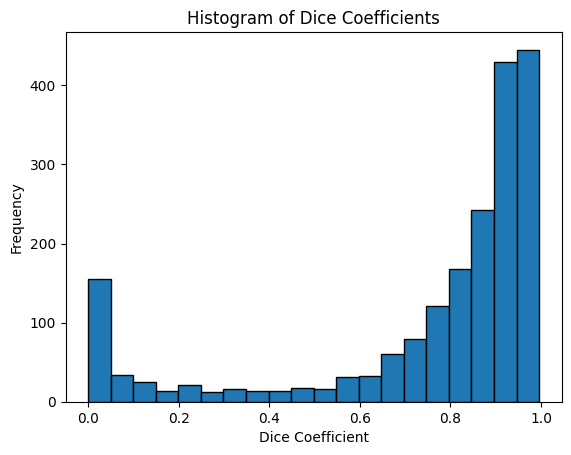

In [45]:
def test_efficacity(nombre_masques):
    files = os.listdir('Train/train')
    segmentation_masks = [file for file in files if file.endswith('_seg.png')]
    if nombre_masques < len(segmentation_masks):
        segmentation_masks = segmentation_masks[:nombre_masques]

    images = [file for file in files if file.endswith('.jpg')]
    moyenne = 0
    dice =[]
    for image_file in tqdm(images):
        mask_file = image_file.replace('.jpg', '_seg.png')
        if mask_file in segmentation_masks:
            image_path = f'Train/train/{image_file}'
            mask_path = f'Train/train/{mask_file}'
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            image_processed, computed_mask = preprocess_image(image_path)
            dice_coefficient = dice_coeff(computed_mask, mask)
            dice.append(dice_coefficient)
            moyenne+= dice_coefficient/len(segmentation_masks)
    return moyenne, dice

mean_dice, dice = test_efficacity(10000)
print(np.median(dice))
print(mean_dice)
# afficher l'histogramme des valeurs de dice
plt.hist(dice, bins=20, edgecolor='black')
plt.title('Histogram of Dice Coefficients')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.show()

On observe bien sur l'histogramme, la médiane et la moyenne que les résultats sont relativement très corrects. Un partie des images n'ont pas été segmentés ou mal et résulte en un dice de 0 mais la médiane étant à 0.87, on est certain que la moitié des images sont très bien segmentées.

Dans les fonctions ci-dessous, on enregistre dans deux dossiers distincts l'ensemble des masques et des images prétraitées. On gardera le masque, si celui existe pour améliorer les résultats des algorithmes de classification.

In [ ]:
def save_preprocessed_images_train(images, output_dir):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in tqdm(range(len(images))):

        original_image_name = images[i].split('/')[-1].split('.')[0]
        original_image_name = original_image_name.split('\\')[-1]
        preprocessed_image, preprocessed_mask = preprocess_image(images[i])

        # Convert les images en uint8 pour pouvoir les enregistrer
        preprocessed_image = (preprocessed_image ).astype('uint8')
        preprocessed_mask = (preprocessed_mask * 255).astype('uint8')

        # si un masque existe déjà, on garde le masque déjà fait 
        if os.path.exists(f'Train/train/{original_image_name}_seg.png'):
            preprocessed_mask = cv2.imread(f'Train/train/{original_image_name}_seg.png', cv2.IMREAD_GRAYSCALE)

        # conversion en bgr 
        preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_RGB2BGR)

        cv2.imwrite(os.path.join(output_dir, f'{original_image_name}.jpg'), preprocessed_image)
        cv2.imwrite(os.path.join(output_dir, f'{original_image_name}_mask.png'), preprocessed_mask)

def save_preprocessed_images_test(images, output_dir):


    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    for i in tqdm(range(len(images))):
        
        original_image_name = images[i].split('/')[-1].split('.')[0]
        original_image_name = original_image_name.split('\\')[-1]
        preprocessed_image, preprocessed_mask = preprocess_image(images[i])


        preprocessed_image = (preprocessed_image ).astype('uint8')
        preprocessed_mask = (preprocessed_mask * 255).astype('uint8')
 
        if os.path.exists(f'Test/test/{original_image_name}_seg.png'):
            preprocessed_mask = cv2.imread(f'Test/test/{original_image_name}_seg.png', cv2.IMREAD_GRAYSCALE)

        preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_RGB2BGR)

        cv2.imwrite(os.path.join(output_dir, f'{original_image_name}.jpg'), preprocessed_image)
        cv2.imwrite(os.path.join(output_dir, f'{original_image_name}_mask.png'), preprocessed_mask)

save_preprocessed_images_train(images_train,'preprocessed_images_train_1')
save_preprocessed_images_test(images_test,'preprocessed_images_test_1')

On remarque qu'il y a quelques problèmes pour certaines images à cause de la règle 1 cependant, de manière plus général on on a des résultats plus satisfaisants en considérant cette règle.  On a pas supprimer les fragments violets pour une raison de temps que je ne pouvais plus accorder à la segmentation. 

---
## <center> **Partie III : Extraction de features**<center>

On importe ci-dessous les librarires nécessaires pour appliquer le random forest et extraire les features

In [65]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from scipy import ndimage
from scipy.ndimage import rotate
from scipy import stats

---
#### **A. Analyse des métadonnées**
---

Tout d'abord, nous allons analyser les données déjà disponibles pour voir si on peut en tirer des informations.

In [137]:
df = pd.read_csv('metadataTrain.csv')
df.shape[0]
df.head()

ID  CLASS     SEX   AGE         POSITION
0  ISIC_0028766      2    male  30.0              NaN
1  ISIC_0071222      8    male  85.0  lower extremity
2  ISIC_0069434      3    male  85.0        head/neck
3  ISIC_0062098      1    male  55.0        head/neck
4  ISIC_0057224      8  female  45.0  lower extremity

On remarque déjà qu'il y a des valeurs non attribuées, pour appliquer l'algorithme de machine learning, il va falloir remplacer ces valeurs. 

1. Pour le sexe, on a plus de valeur qui représente au sex masculin, donc on va établir toutes les valeurs NaN associées au sexe à la valeur male.
2. Pour l'âge, on va remplacer les valeurs non attribuées par la valeur moyenne de l'âge.
3. Enfin, pour la position de la lésion, on va ajouter une valeur *unknown* qu'on attribuera à toutes les valeurs non attribuées.

In [138]:
# Remplacer les valeurs manquantes dans la colonne SEX par la valeur male
df['SEX'].fillna('male', inplace=True)

# Remplacer les valeurs manquantes dans la colonne 'AGE' par la moyenne des âges
df['AGE'].fillna(df['AGE'].mean(), inplace=True)

# Remplacer les valeurs manquantes dans la colonne 'position' par 'unknown'
df['POSITION'].fillna('unknown', inplace=True)

# on vérifie qu'il y a bien aucune valeur Nan.
df.isna().sum()

ID          0
CLASS       0
SEX         0
AGE         0
POSITION    0
dtype: int64

Par ailleurs, on essaiera d'avoir que des valeurs numériques pour appliquer un algorithme random forest. Pour cela, on peut utiliser un one hot encoder pour ne pas avoir de relation d'ordre entre les positions par exemple.

In [139]:
le = LabelEncoder()
# Conversion des valeurs 'male' et 'female' en 1 et 0 respectivement
df['SEX'] = le.fit_transform(df['SEX'])

ohe = OneHotEncoder()
position_encoded = ohe.fit_transform(df[['POSITION']]).toarray()
# Création de nouvelles colonnes pour chaque position unique
for i, category in enumerate(ohe.categories_[0]):
    df[category] = position_encoded[:, i]
# Suppression de la colonne 'position' originale
df = df.drop('POSITION', axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  posterior torso  unknown  \
0              0.0           0.0          0.0              0.0      1.0   
1              1.0           0.0          0.0              0.0      0.0   
2              0.0           0.0          0.0              0.0      0.0   
3              0.0           0.0          0.0              0.0      0.0   
4              1.0           0.0          0.0              0.0      0.0   

   upper extremity  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

Maintenant, on pourra exploiter ces données lors des algorithmes de classfication.
Il est important avant de jeter un coup d'oeil sur la répartition des données en fonction des classes par exemple ou de l'âge.

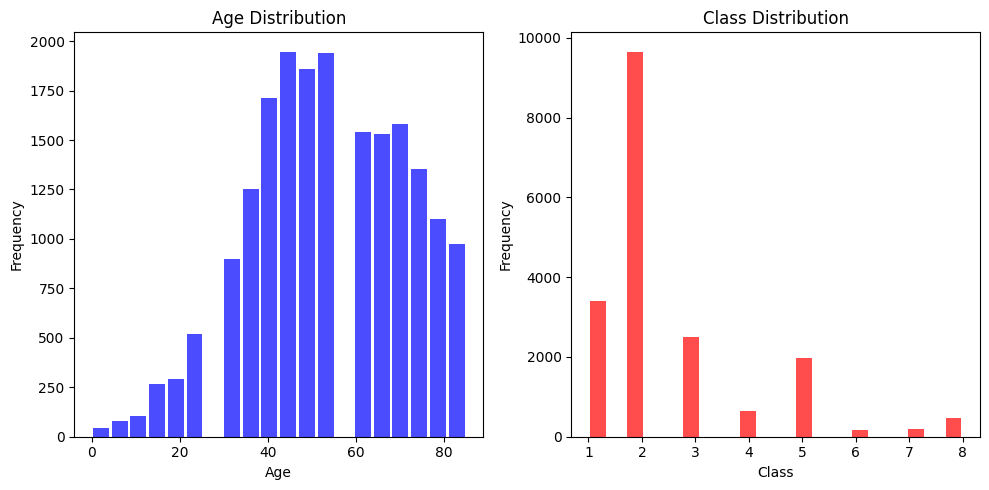

In [140]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(df['AGE'], bins=20, color='b', alpha=0.7, rwidth=0.85)
ax[0].set_title('Age Distribution')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')

ax[1].hist(df['CLASS'], bins=20, color='r', alpha=0.7, rwidth=0.85)
ax[1].set_title('Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

L'âge semble assez bien réparti sur le graphique ci-dessus. Cependant, on observe que la répartition des classes est assez déséquilibrée. Si on ne fait rien, l'algorithme va donc apprendre à tout mettre dans la classe 2 pour minimiser la fonction de coût et on ne pourra jamais avoir de données dans les classes 6,7,8. D'où l'importance de la métrique pondérée suivante :
$$WA = \frac 1 N  \sum_{i=1}^N w_i I(y_i =f_i)$$  
avec $ \sum_{i=1}^N w_i = N$  
Ici $y_i$ est la classe réelle d'une lésion, $f_i$ est la prédiction de la classe et $w_i$ est le poids associé à l'image i. On associe le même poids pour toutes les images d'une même classe.  
Soit $G={G_1,…,G_K}$  les K classes, on a $w_t = \frac{ N }{ k |G_t|}$. Plus il y a d'éléments dans une classe, plus son poids est donc faible. 

Les poids du set de test sont données :  
$$ [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]$$


Cette métrique peut permetrre aussi d'insister, plus sur les erreurs graves. Par exemple si la classe 7 correspond à des cancers, il est plus intéressant de ne pas mal classé les cancers alors que classé dans les cancers une lésion bénine est moins grave. 

L'upsample est cependant nécessaire pour appliquer un random forest. La meilleur solution serait d'appliquer un bruit gaussien de bruit très faible 0.0001 par exemple comme mentionné dans l'article *Classification of Melanoma Lesions Using Sparse Coded Features and Random Forests* écrit par Mojdeh Rastgoo, Guillaume Lemaître, Olivier Morel, Johan Massich, Rafael Garcia, Fabrice Mériaudeau, Frank Marzani, Désiré Sidibé en janvier 2016.  

On devrait également appliquer des rotations de l'image mais cela imposerait de créer de nouvelles images, de créer leur masque, mais j'aurai beaucoup de mal à faire tourner mes algorithmes avec autant de données.

Il nous reste donc deux possibilités: la première est de simplement upsample les données en duppliquant les lignes. cette opération se ferait donc à la fin pour ne pas calculer plusieurs fois les mêmes features. Une deuxième méthode peut-être de duppliquer les données avant l'extraction de features et d'ajouter un bruit au masque et à l'image avant chaque calcul de features, pour ne pas sauvegarder 70 000 images sur le dossier. 
Le masque ne changeant pas avec le bruit. On va commencer par calculer toutes les features relatives uniquement aux masques, puis on duppliquer les données et on calculera les informations sur les couleurs avec le bruit issu de la loi normale $\mathcal{N}(0, 0.0001)$.

**Pour l'extraction de features, on va suivre la règle des features ABCD: les features relatives à l'asymmétrie de la lésion, aux irrégularités de la bordure, aux couleurs de la lésion et enfin aux diamètres et à la taille de lésion sont les caractéristiques principales permettant de distinguer entre les différentes classes. On va donc commencer par étudier l'asymmétrie des lésions.**


---
#### **B.  Extraction de la donnée d'asymmétrie**
---

Dans l'article *Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists* de M. Zortea, T. R. Schopf, plusieurs méthodes de calculs d'asymmétrie sont données et on va donc essayer de les implémenter.

La première qui donne deux features, l'asymmétrie verticale et l'asymmétrie horizontale consiste à recentrer l'image par rapport à son centre de gravité puis de calculer la différence entre les deux côtés de l'image verticalement et horizontalement. On effectue des rotations du masques jusqu'à 180° pour prendre la direction ou la symétrie est la plus grande. 

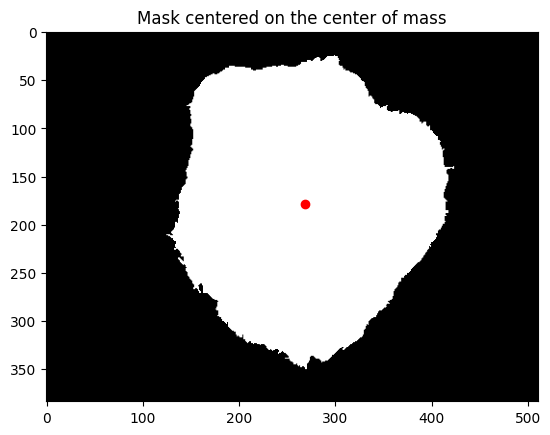

In [141]:
mask = imread('preprocessed_images_train_1/ISIC_0000003_mask.png')
# Calculer le centre de masse du masque
center_of_mass = ndimage.center_of_mass(mask)

# Créer une grille de coordonnées pour le masque, centrée sur le centre de masse
x = np.arange(mask.shape[1])
y = np.arange(mask.shape[0])
x_grid, y_grid = np.meshgrid(x - center_of_mass[1], y - center_of_mass[0])

plt.imshow(mask, cmap='gray')
plt.scatter(center_of_mass[1], center_of_mass[0], color='red')  # centre de masse
plt.title('Mask centered on the center of mass')
plt.show()

Dans l'article il est mentionné qu'il est bon de faire tourner l'image de 10° jusqu' 180°. Cependant, pour réduire le temps de calcul, nous allons faire 4 rotations de 45° puis prendre les deux valeurs qui minimise leur somme.

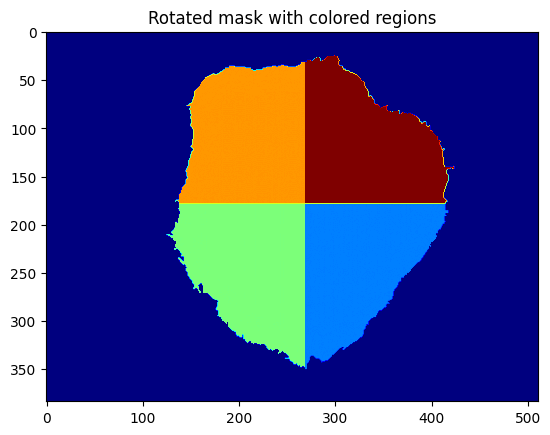

0.0058761169165530815 0.013327275480842041


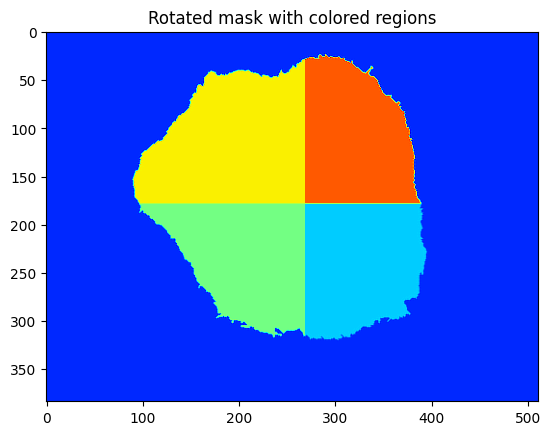

0.05740611969919443 0.08255747395197884


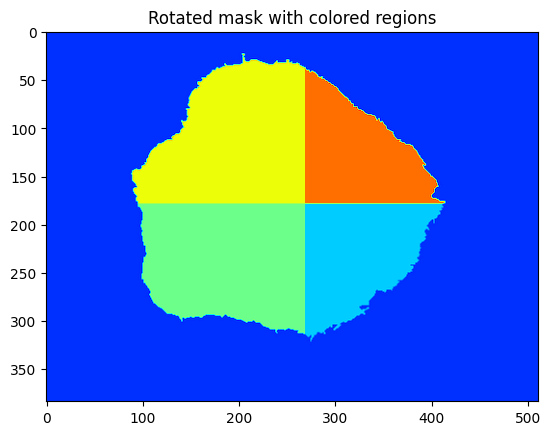

0.008520105744349334 0.22864071703274438


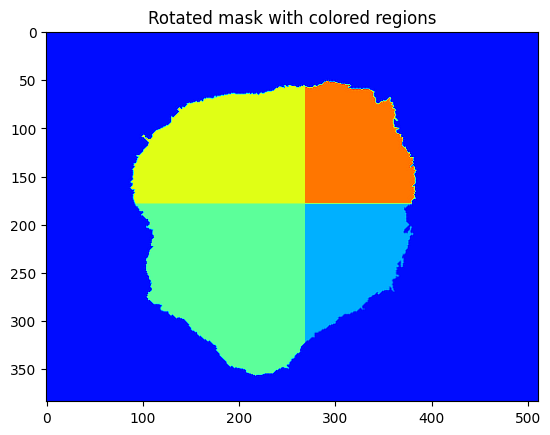

0.07820574202889159 0.28415010743219954


(0.0058761169165530815, 0.013327275480842041)

In [142]:
mask = mask / mask.max()
# Initialiser les scores d'asymétrie au maximum possible
min_asymmetry_score = float('inf')
min_S1 = min_S2 = 0

# Essayer plusieurs angles de rotation
for angle in range(0, 180, 45):
    # Faire pivoter le masque
    rotated_mask = rotate(mask, angle, reshape=False) 
    # Diviser le masque pivoté en quatre régions
    indices = np.where((x_grid >= 0) & (y_grid >= 0))
    A1 = rotated_mask[indices]

    indices = np.where((x_grid < 0) & (y_grid >= 0))
    A2 = rotated_mask[indices]

    indices = np.where((x_grid < 0) & (y_grid < 0))
    A3 = rotated_mask[indices]

    indices = np.where((x_grid >= 0) & (y_grid < 0))
    A4 = rotated_mask[indices]
    
    # Afficher les régions A1, A2, A3 et A4
    # Créer une copie du masque pivoté pour l'affichage
    display_mask = rotated_mask.copy()

    # Colorier les régions A1, A2, A3 et A4
    display_mask[(x_grid >= 0) & (y_grid >= 0)] = 1*rotated_mask[(x_grid >= 0) & (y_grid >= 0)]  # A1
    display_mask[(x_grid < 0) & (y_grid >= 0)] = 2*rotated_mask[(x_grid < 0) & (y_grid >= 0)]  # A2
    display_mask[(x_grid < 0) & (y_grid < 0)] = 3*rotated_mask[(x_grid < 0) & (y_grid < 0)]  # A3
    display_mask[(x_grid >= 0) & (y_grid < 0)] = 4*rotated_mask[(x_grid >= 0) & (y_grid < 0)]  # A4

    # Afficher le masque avec les régions colorées
    plt.imshow(display_mask, cmap='jet')
    plt.title('Rotated mask with colored regions')
    plt.show()
    
    # Calculer les scores d'asymétrie
    # Calculer les sommes de A1, A2, A3 et A4
    sum_A1 = A1.sum()
    sum_A2 = A2.sum()
    sum_A3 = A3.sum()
    sum_A4 = A4.sum()

    # Calculer les scores d'asymétrie
    S1 = np.abs((sum_A1 + sum_A2) - (sum_A3 + sum_A4))
    S2 = np.abs((sum_A1 + sum_A4) - (sum_A2 + sum_A3))
    # Normaliser les scores d'asymétrie par la surface du masque
    S1 /= mask.sum()
    S2 /= mask.sum()

    print(S1, S2)
    # Mettre à jour le score d'asymétrie minimum et les scores correspondants S1 et S2
    if (S1 + S2) / 2 < min_asymmetry_score:
        min_asymmetry_score = (S1 + S2) / 2
        min_S1 = S1
        min_S2 = S2
    
min_S1, min_S2

In [143]:
def is_symmetric(masque):    

    center_of_mass = ndimage.center_of_mass(masque)

    x = np.arange(masque.shape[1])
    y = np.arange(masque.shape[0])
    x_grid, y_grid = np.meshgrid(x - center_of_mass[1], y - center_of_mass[0])
    
    min_asymmetry_score = float('inf')
    min_S1 = min_S2 = 0

    mask = masque / masque.max()

    mask_sum = mask.sum()
    
    for angle in range(0, 180, 45):
        rotated_mask = rotate(mask, angle, reshape=False)
        
        indices = np.where((x_grid >= 0) & (y_grid >= 0))
        A1 = rotated_mask[indices]

        indices = np.where((x_grid < 0) & (y_grid >= 0))
        A2 = rotated_mask[indices]

        indices = np.where((x_grid < 0) & (y_grid < 0))
        A3 = rotated_mask[indices]

        indices = np.where((x_grid >= 0) & (y_grid < 0))
        A4 = rotated_mask[indices]

        sum_A1 = A1.sum()
        sum_A2 = A2.sum()
        sum_A3 = A3.sum()
        sum_A4 = A4.sum()

        S1 = np.abs((sum_A1 + sum_A2) - (sum_A3 + sum_A4))
        S2 = np.abs((sum_A1 + sum_A4) - (sum_A2 + sum_A3))
        S1 /= mask_sum
        S2 /= mask_sum

        if (S1 + S2) / 2 < min_asymmetry_score:
            min_asymmetry_score = (S1 + S2) / 2
            min_S1 = S1
            min_S2 = S2
    return min_S1, min_S2

Sachant que plus le masque est symmétrique, plus les valeurs des features sont faibles. On va afficher les masques dont les valeurs d'asymmétrie sont hautes pour voir si notre algorithme fonctionne. 

  0%|          | 0/18998 [00:00<?, ?it/s]

  0%|          | 2/18998 [00:01<3:21:06,  1.57it/s]

0.11008675053618874 0.02871410736579276
preprocessed_images_train_1/ISIC_0069434_mask.png


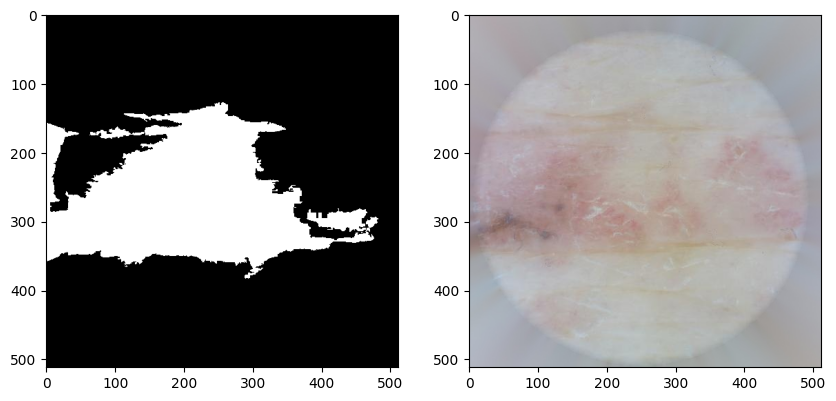

In [144]:
for i in tqdm(range(0, df.shape[0])):
    mask = imread('preprocessed_images_train_1/' + df['ID'][i] + '_mask.png')
    min1, min2= is_symmetric(mask) 
    if min1 > 0.1 or min2 > 0.1:
        print(min1, min2)
        fig,ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(mask, cmap='gray')
        ax[1].imshow(imread('preprocessed_images_train_1/' + df['ID'][i] + '.jpg'), cmap='gray')
        print('preprocessed_images_train_1/' + df['ID'][i] + '_mask.png')
        break

La fonction semble fonctionnait puisque la lésion est asymétrique. Il ne suffit donc plus qu'à ajouter ces deux features à tout le dataset:

In [145]:
def apply_asymmetry(mask):
    S1, S2 = is_symmetric(mask)
    return pd.Series([S1, S2])

In [146]:
# Appliquer la fonction is_symmetric à chaque masque et ajouter les résultats en tant que nouvelles colonnes
df[['asymmetry1', 'asymmetry2']] = df.apply(lambda row: apply_asymmetry(imread('preprocessed_images_train_1/' + str(row['ID']) + '_mask.png')), axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  posterior torso  unknown  \
0              0.0           0.0          0.0              0.0      1.0   
1              1.0           0.0          0.0              0.0      0.0   
2              0.0           0.0          0.0              0.0      0.0   
3              0.0           0.0          0.0              0.0      0.0   
4              1.0           0.0          0.0              0.0      0.0   

   upper extremity  asymmetry1  asymmetry2  
0              0.0    0.032440    0.007757  
1              0.0    0.037859    0.000519  
2              0.0    0.110087    0.028714  
3              0.0    0.007169    0.090567  
4              0.0    0.082215    0.183138

On va calculer une nouvelle mesure d'asymétrie pour rajouter deux nouvelles features. L'asymétrie de l'intensité des couleurs. Pour cela on va faire le calcul suivant :
Avec les mêmes régions A1, A2, A3, A4  

$$ \Delta C1 = \sum_{a=0}^{255} |  \hat{C}_{A1 \cup A2}(a) - \hat{C}_{A3 \cup A4}(a) | $$
$$ \Delta C2 = \sum_{a=0}^{255} |  \hat{C}_{A1 \cup A4}(a) - \hat{C}_{A2 \cup A3}(a) | $$

où $ \hat{C}_{A1 \cup A2}(a)$ est la distribution de 256 niveau de gris a utilisant les pixels des régions de A1 et A2.

Après avoir divisé la zone dans les 4 régions :
- A1 : Haut droit
- A2 : Haut gauche
- A3 : Bas gauche
- A4 : Bas droit

On calcule les histogrammes en niveaux de gris des zones combinées des quadrants opposés.
On calcule ensuite les différences entre les histogrammes des quadrants opposés pour obtenir les mesures d'asymmétrie : $\Delta C1$ et $\Delta C2$ qui réfletent donc 

In [147]:
def color_intensity_asymmetry(image, mask):    
    # Calculer le centre de masse du masque
    center_of_mass = ndimage.center_of_mass(mask)

    # Créer une grille de coordonnées pour le masque, centrée sur le centre de masse
    x = np.arange(mask.shape[1])
    y = np.arange(mask.shape[0])
    x_grid, y_grid = np.meshgrid(x - center_of_mass[1], y - center_of_mass[0])
    
    mask = mask / mask.max()

    # Diviser le masque pivoté en quatre régions
    indices = np.where((x_grid >= 0) & (y_grid >= 0))
    A1 = image[indices]

    indices = np.where((x_grid < 0) & (y_grid >= 0))
    A2 = image[indices]

    indices = np.where((x_grid < 0) & (y_grid < 0))
    A3 = image[indices]

    indices = np.where((x_grid >= 0) & (y_grid < 0))
    A4 = image[indices]

    # Calculer les histogrammes de niveaux de gris pour A1, A2, A3 et A4
    hist_A1_A2, _ = np.histogram(np.concatenate([A1, A2]), bins=256, range=(0, 256))
    hist_A3_A4, _ = np.histogram(np.concatenate([A3, A4]), bins=256, range=(0, 256))
    hist_A1_A4, _ = np.histogram(np.concatenate([A1, A4]), bins=256, range=(0, 256))
    hist_A2_A3, _ = np.histogram(np.concatenate([A2, A3]), bins=256, range=(0, 256))
    # Calculer les différences absolues entre les histogrammes
    delta_C1 = np.abs(hist_A1_A2 - hist_A3_A4).sum()
    delta_C2 = np.abs(hist_A1_A4 - hist_A2_A3).sum()
    # Retourner les deux caractéristiques d'asymétrie
    return delta_C1, delta_C2

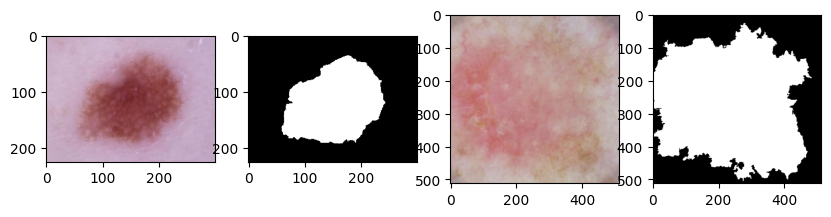

(52862, 49092)
(109248, 250794)


In [148]:
k1, k2 = 500, 450
# charger l'image correspondante
image1 = imread('preprocessed_images_train_1/' + df['ID'][k1] + '.jpg')
image2 = imread('preprocessed_images_train_1/' + df['ID'][k2] + '.jpg')

# charger le masque correspondant
mask1 = imread('preprocessed_images_train_1/' + df['ID'][k1] + '_mask.png')
mask2 = imread('preprocessed_images_train_1/' + df['ID'][k2] + '_mask.png')

# Affichage des images
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].imshow(image1)
ax[1].imshow(mask1, cmap='gray')
ax[2].imshow(image2)
ax[3].imshow(mask2, cmap='gray')

plt.show()

print(color_intensity_asymmetry(image1, mask1))
print(color_intensity_asymmetry(image2, mask2))


Les résultats semblent cohérents pour ces deux images mais il me semble d'estimer la symétrie des couleurs à vue d'oeil la plupart du temps. On voit que ces features ont des valeurs très élevées, ce qui peut-être embetant pour certains algorithmes de machines learning. Néanmoins, pour un random forest ce n'est pas nécessaire de les normaliser.

In [149]:
def apply_color_intensity_asymmetry(image, mask):
    delta_C1, delta_C2 = color_intensity_asymmetry(image, mask)
    return pd.Series([delta_C1, delta_C2])

In [150]:
df[['color_asymmetry1', 'color_asymmetry2']] = df.apply(lambda row: apply_color_intensity_asymmetry(imread('preprocessed_images_train_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_train_1/' + row['ID'] + '_mask.png')), axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  posterior torso  unknown  \
0              0.0           0.0          0.0              0.0      1.0   
1              1.0           0.0          0.0              0.0      0.0   
2              0.0           0.0          0.0              0.0      0.0   
3              0.0           0.0          0.0              0.0      0.0   
4              1.0           0.0          0.0              0.0      0.0   

   upper extremity  asymmetry1  asymmetry2  color_asymmetry1  color_asymmetry2  
0              0.0    0.032440    0.007757             21956             19384  
1              0.0    0.037859    0.000519            166410            312564  
2              0.0    0.110087    0.028714            143754            216106  
3              0.0    0.007169    0.090567            126074             79486  
4              0.0    0.082215    0.183138            337286            357950

---
#### **C.  Extraction de la donnée d'asymétrie de la bordure**
---

Nous allons maintenant calculer les features relatives à la bordure des lésions.  
La première feature que nous allons  calculer est la régularité de la bordure.  

On va calculer cette feature en appliquant un cercle autour du masque et en faisant les différences entre le cercle le plus proche et les points à la bordure du masque.  

In [151]:
def border_features(mask):
    # Calculer le centre de masse du masque
    center = ndimage.center_of_mass(mask)

    # Calculer le rayon du masque (la distance maximale du centre à un pixel du masque)
    y, x = np.where(mask)
    radius = max(np.sqrt((y - center[0])**2 + (x - center[1])**2))

    # Créer un cercle avec le même centre et le même rayon
    y, x = np.ogrid[-center[0]:mask.shape[0]-center[0], -center[1]:mask.shape[1]-center[1]]
    circle = x**2 + y**2 <= radius**2

    # Trouver les coordonnées des pixels du bord du masque
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    border_pixels = np.concatenate(contours).squeeze()

    # Calculer la distance entre chaque pixel du bord et le cercle
    distances = np.abs(np.sqrt((border_pixels[:, 0] - center[0])**2 + (border_pixels[:, 1] - center[1])**2) - radius)

    # Faire la somme des distances
    total_distance = np.sum(distances)

    return total_distance

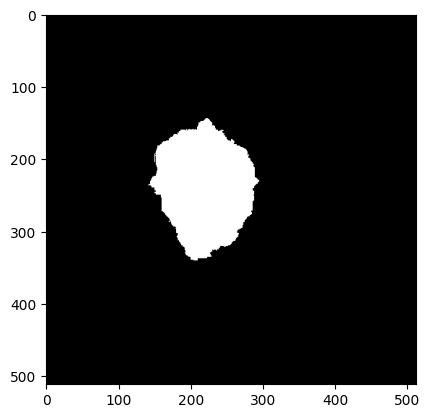

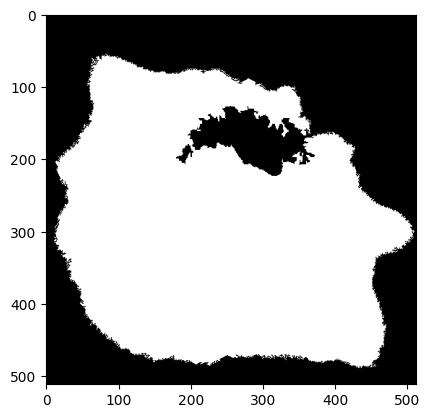

13884.555636362758 339757.94940088823


In [152]:
k1 = 1
k2 = 10
# charger l'image correspondante
mask = imread('preprocessed_images_train_1/' + df['ID'][k1] + '_mask.png')
plt.imshow(mask, cmap='gray')
plt.show()

# Calcul des caractéristiques  
features1 = border_features(mask)
mask = imread('preprocessed_images_train_1/' + df['ID'][k2] + '_mask.png')
plt.imshow(mask, cmap='gray')
plt.show()

features2 = border_features(mask)


print(features1, features2)

In [153]:
def apply_border_features(mask):
    total_distance = border_features(mask)
    return pd.Series([total_distance])

In [154]:
df['border_features'] = df.apply(lambda row: apply_border_features(imread('preprocessed_images_train_1/' + row['ID'] + '_mask.png')), axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  posterior torso  unknown  \
0              0.0           0.0          0.0              0.0      1.0   
1              1.0           0.0          0.0              0.0      0.0   
2              0.0           0.0          0.0              0.0      0.0   
3              0.0           0.0          0.0              0.0      0.0   
4              1.0           0.0          0.0              0.0      0.0   

   upper extremity  asymmetry1  asymmetry2  color_asymmetry1  \
0              0.0    0.032440    0.007757             21956   
1              0.0    0.037859    0.000519            166410   
2              0.0    0.110087    0.028714            143754   
3              0.0    0.007169    0.090567            126074   
4              0.0    0.082215    0.183138            337286   

   color_asymmetry2  border_features  
0             19384      5188.153605  
1            312564     13884.555636  
2            216106    334267.115835  
3             79486    339151.631884  
4            357950    443290.464026

On va également calculé des features relatives au gradient de l'image : On crée un masque de six pixels de large grâce à des opérations morphologiques. Les caractéristiques de gradient sont **le minimum, le maximum, la moyenne et la variance des valeurs de gradient** calculées par l'application des opérateurs de Sobel à l'intérieur du masque extrait pour la zone frontalière.

Pour cela, nous allons créé un masque de la zone frontalière : on va dilater le masque initiale puis appliquer une érosion au masque dilaté, et enfin soustraire les deux masques pour avoir un masque de bordure de six pixels de large.  
On calcule enfin le gradient avec l'opérateur de Sobel, pour obtenir les gradients dans les directions x et y et on extraira les features mentionnées ci-dessus.

On extraira également comme mentionné dans l'article *Automated Melanoma Recognition* les features de **minimum, maximum, moyenne et variance** de l'image normalisé en intensité dans la zone de la frontière. On normalise l'intensité pour que la pigmentation de la peau n'affecte pas le résultat.

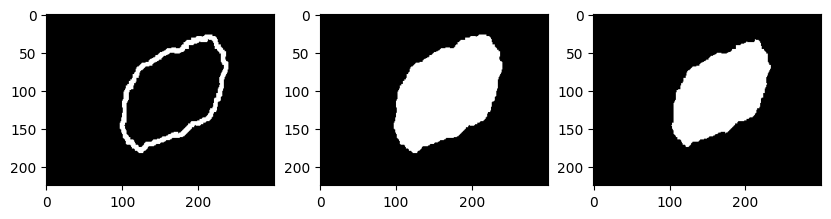

{'min_gradient': 4.0, 'max_gradient': 3029.6630175648247, 'mean_gradient': 753.4282410650687, 'variance_gradient': 183766.25629312266, 'min_intensity': 0.15294117647058825, 'max_intensity': 0.9686274509803922, 'mean_intensity': 0.5837658067620063, 'variance_intensity': 0.044633434232577845}


In [155]:
def calculate_features_test(image, mask):
    # Créer le masque de bordure en utilisant des opérations morphologiques
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    border_mask = dilated_mask - eroded_mask

    fig,ax = plt.subplots(1,3,figsize=(10,5))
    ax[0].imshow(border_mask, cmap='gray')
    ax[1].imshow(dilated_mask, cmap='gray')
    ax[2].imshow(eroded_mask, cmap='gray')
    plt.show()
    # Calculer les gradients avec l'opérateur de Sobel
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Extraire les valeurs de gradient dans la zone de bordure
    border_gradients = grad_magnitude[border_mask > 0]
    gradient_features = {
        'min_gradient': np.min(border_gradients),
        'max_gradient': np.max(border_gradients),
        'mean_gradient': np.mean(border_gradients),
        'variance_gradient': np.var(border_gradients)
    }

    # Normaliser l'image et calculer les caractéristiques d'intensité dans la zone de bordure
    normalized_image = image / np.max(image)
    border_intensities = normalized_image[border_mask > 0]
    intensity_features = {
        'min_intensity': np.min(border_intensities),
        'max_intensity': np.max(border_intensities),
        'mean_intensity': np.mean(border_intensities),
        'variance_intensity': np.var(border_intensities)
    }

    # Renvoyer toutes les caractéristiques
    return {**gradient_features, **intensity_features}

k1 = 30
# charger l'image correspondante
image = imread('preprocessed_images_train_1/' + df['ID'][k1] + '.jpg')
mask = imread('preprocessed_images_train_1/' + df['ID'][k1] + '_mask.png')
# Calcul des caractéristiques
features = calculate_features_test(image, mask)
print(features)


In [156]:
def calculate_features_grad(image, mask):
    # Créer le masque de bordure en utilisant des opérations morphologiques
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    border_mask = dilated_mask - eroded_mask
    
    # Calculer les gradients avec l'opérateur de Sobel
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Extraire les valeurs de gradient dans la zone de bordure
    border_gradients = grad_magnitude[border_mask > 0]
    if border_gradients.size > 0:
        min_gradient = np.min(border_gradients)
        max_gradient = np.max(border_gradients)
        mean_gradient = np.mean(border_gradients)
        variance_gradient = np.var(border_gradients)
    else:
        min_gradient = max_gradient = mean_gradient = variance_gradient = 0.


    # Normaliser l'image et calculer les caractéristiques d'intensité dans la zone de bordure
    normalized_image = image / np.max(image)
    border_intensities = normalized_image[border_mask > 0]
    if border_intensities.size > 0:
        min_intensity = np.min(border_intensities)
        max_intensity = np.max(border_intensities)
        mean_intensity = np.mean(border_intensities)
        variance_intensity = np.var(border_intensities)
    else:
        min_intensity = max_intensity = mean_intensity = variance_intensity = 0.

    return min_gradient, max_gradient, mean_gradient, variance_gradient, min_intensity, max_intensity, mean_intensity, variance_intensity

In [157]:
def apply_gradient_intensity_features(image, mask):
    min_gradient, max_gradient, mean_gradient, variance_gradient, min_intensity, max_intensity, mean_intensity, variance_intensity = calculate_features_grad(image, mask)
    return pd.Series([min_gradient, max_gradient, mean_gradient, variance_gradient, min_intensity, max_intensity, mean_intensity, variance_intensity])

In [158]:
df[['min_gradient', 'max_gradient', 'mean_gradient', 'variance_gradient', 'min_intensity', 'max_intensity', 'mean_intensity', 'variance_intensity']] = df.apply(lambda row: apply_gradient_intensity_features(imread('preprocessed_images_train_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_train_1/' + row['ID'] + '_mask.png')), axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  ...  color_asymmetry2  \
0              0.0           0.0          0.0  ...             19384   
1              1.0           0.0          0.0  ...            312564   
2              0.0           0.0          0.0  ...            216106   
3              0.0           0.0          0.0  ...             79486   
4              1.0           0.0          0.0  ...            357950   

   border_features  min_gradient  max_gradient  mean_gradient  \
0      5188.153605     19.235384   3115.825733     937.513914   
1     13884.555636      2.828427    780.544682     244.718736   
2    334267.115835      0.000000   1150.530313     191.283634   
3    339151.631884      0.000000   3520.745660     365.913237   
4    443290.464026      0.000000   2103.918725     317.910193   

   variance_gradient  min_intensity  max_intensity  mean_intensity  \
0      353463.808479       0.206422       0.917431        0.647290   
1       18506.867796       0.365546       0.966387        0.682987   
2       19728.569442       0.632558       0.911628        0.796001   
3       95092.932179       0.294872       0.974359        0.749273   
4       76872.656360       0.524000       0.856000        0.688811   

   variance_intensity  
0            0.013566  
1            0.035750  
2            0.001682  
3            0.007340  
4            0.001369  

[5 rows x 26 columns]

---
#### **D.  Extraction des features liées au diamètre, la taille et la forme de la lésion**
---

On va extraire les features liées à la forme de la lésion :
1. L'aire et le périmètre de la lésion 
2. la longueur et la largeur du rectangle le plus petit qui peut entièrement contenir le contour
3. La mesure polaire, c'est-à-dire le rayon maximale en utilisant le centre du cercle englobant minimal 
4. Des caractéristiques de formes: un indicateur de la proximité de la forme à un cercle parfait (cette feature semble être assez proche de la border feature calculé précédemment), la roundness et enfin l'extent c'est-à-dire le rapport de l'aire de la forme à l'aire de son rectangle englobant, indiquant combien la forme remplit son rectangle englobant.

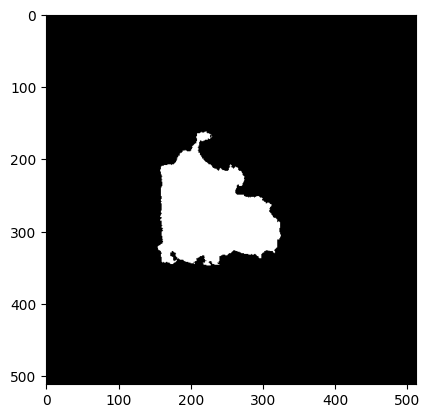

(18362.0, 895.0336118936539, 171, 186, 0.288038908836891, 2.1230559556730526, 0.5773124567691631, 104.9383739775451)


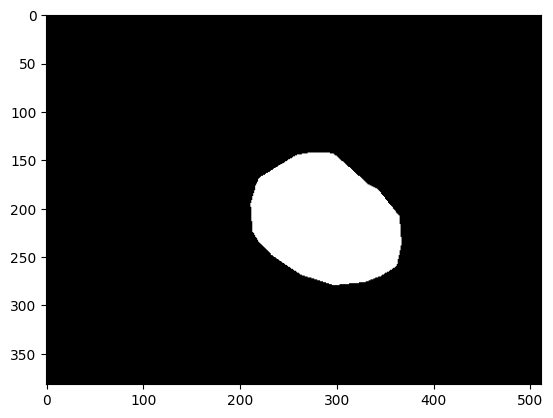

(15618.0, 480.07315719127655, 156, 137, 0.8515701612654231, 2.8321816214596796, 0.7307692307692307, 83.79289946051514)


In [159]:
def calculate_form_features(mask):
    # Trouver les contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)  # Prendre le contour le plus grand pour analyse

    # Calcul de l'aire et du périmètre
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Rectangle englobant
    x, y, w, h = cv2.boundingRect(contour)
    bounding_rect_area = w * h

    # Mesures polaires (rayon maximal ici comme exemple simple)
    center = cv2.minEnclosingCircle(contour)[0]  # Centre du cercle englobant minimal
    max_radius = max(np.sqrt((pt[0][0] - center[0])**2 + (pt[0][1] - center[1])**2) for pt in contour)

    # Caractéristiques de forme
    form_factor = (4 * np.pi * area) / (perimeter ** 2)
    roundness = (4 * area) / (np.pi * max_radius ** 2)  # utilisant le rayon du cercle englobant minimal
    extent = area / bounding_rect_area

    return area, perimeter, w, h, form_factor, roundness, extent, max_radius

k1 = 31
# charger l'image correspondante
mask = imread('preprocessed_images_train_1/' + df['ID'][k1] + '_mask.png')
plt.imshow(mask, cmap='gray')
plt.show()
# Calcul des caractéristiques
features = calculate_form_features(mask)
print(features)


k2 = 36
# charger l'image correspondante
mask = imread('preprocessed_images_train_1/' + df['ID'][k2] + '_mask.png')
plt.imshow(mask, cmap='gray')
plt.show()
# Calcul des caractéristiques
features = calculate_form_features(mask)
print(features)

In [160]:
def apply_form_features(mask):
    area, perimeter, w, h, form_factor, roundness, extent, max_radius = calculate_form_features(mask)
    return pd.Series([area, perimeter, w, h, form_factor, roundness, extent, max_radius])

In [161]:
df[['area', 'perimeter', 'width', 'height', 'form_factor', 'roundness', 'extent', 'max_radius']] = df.apply(lambda row: apply_form_features(imread('preprocessed_images_train_1/' + row['ID'] + '_mask.png')), axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  ...  mean_intensity  \
0              0.0           0.0          0.0  ...        0.647290   
1              1.0           0.0          0.0  ...        0.682987   
2              0.0           0.0          0.0  ...        0.796001   
3              0.0           0.0          0.0  ...        0.749273   
4              1.0           0.0          0.0  ...        0.688811   

   variance_intensity     area    perimeter  width  height  form_factor  \
0            0.013566   2719.5   266.208151   50.0    83.0     0.482232   
1            0.035750  18987.0   684.783832  154.0   197.0     0.508814   
2            0.001682  60953.0  3447.301849  482.0   256.0     0.064453   
3            0.007340  72301.0  3535.531417  451.0   390.0     0.072685   
4            0.001369  89124.5  2937.006262  512.0   512.0     0.129837   

   roundness    extent  max_radius  
0   2.042493  0.655301   41.173646  
1   2.493746  0.625849   98.459382  
2   1.222063  0.493979  252.003009  
3   1.370795  0.411058  259.143868  
4   0.869151  0.339983  361.331565  

[5 rows x 34 columns]

On va pouvoir passer à la dernière partie d'extraction des features, celle des features liées à la couleur de l'image. 

---
#### **E.  Extraction des features liées à la couleur de la lésion**
---

Tout d'abord, nous allons calculé la moyenne et l'écart-type des 3 canaux R,G,B de la lésion. Certains articles suggèrent de calculer moyenne, variance et écart-type mais dans la mesure où l'écart-type et la variance ont totalement dépendante, il ne me parait pas utile d'ajouter les trois features associées à la variance.

In [162]:
def compute_color_features(image,mask):
    # calcule la moyenne et l'écart-type pour chaque canal de couleur
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mean,std= cv2.meanStdDev(image,mask=mask)
    mean = mean.flatten()
    std = std.flatten()
    return mean[0], mean[1], mean[2], std[0], std[1], std[2]

In [163]:
def apply_statistical_color_features(image, mask):
    f1, f2, f3, f4, f5, f6, = compute_color_features(image, mask)
    return pd.Series([f1, f2, f3, f4, f5, f6])

In [164]:
df[['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B']] = df.apply(lambda row: apply_statistical_color_features(imread('preprocessed_images_train_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_train_1/' + row['ID'] + '_mask.png')), axis=1)
df.head()

ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  ...  form_factor  roundness  \
0              0.0           0.0          0.0  ...     0.482232   2.042493   
1              1.0           0.0          0.0  ...     0.508814   2.493746   
2              0.0           0.0          0.0  ...     0.064453   1.222063   
3              0.0           0.0          0.0  ...     0.072685   1.370795   
4              1.0           0.0          0.0  ...     0.129837   0.869151   

     extent  max_radius      mean_R      mean_G      mean_B      std_R  \
0  0.655301   41.173646   61.375882   69.517983  115.526798  37.239132   
1  0.625849   98.459382   84.109792  139.622861  207.752308  12.612306   
2  0.493979  252.003009  151.996815  157.978408  175.320737  12.632390   
3  0.411058  259.143868  142.052866  154.068857  187.846675  26.656999   
4  0.339983  361.331565  131.178707  149.328559  164.436329  18.222053   

       std_G      std_B  
0  39.347607  39.055749  
1  11.598617   6.610219  
2  15.027812   9.831880  
3  23.725131  14.260450  
4  13.385228  11.623989  

[5 rows x 40 columns]

Enfin, les dernières features que nous allons calculé sont le minimum, le maximum, la moyenne et la variance des canaux H et I dans l'espace de couleurs HSI. Nous allons normalisé avant tout soustrayant l'intensité moyenne des pixels de peau (la partie où le masque vaut 0 ) pour l'intensité et en prenant soustrayant la valeur de hue qui a la plus grande probabilité dans la partie de la peau pour le canal HUE. 

In [165]:
def calculate_color_features_HUE(image, mask):
    # Convertir RGB en HSV puis ajuster pour HSI
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, saturation, intensity = cv2.split(hsv_image)
    hue = hue / 255.0
    intensity = intensity / 255.0
    
    # Normaliser les canaux
    skin_mask = (mask == 0)
    mean_intensity = np.mean(intensity[skin_mask])
    hue_skin = hue[skin_mask]
    
    mode_result = stats.mode(hue_skin, axis=None)
    mode_hue = mode_result.mode

    norm_intensity = intensity - mean_intensity
    norm_hue = hue - mode_hue
    
    # Calcul des statistiques pour le canal de teinte
    hue_min = np.min(norm_hue)
    hue_max = np.max(norm_hue)
    hue_mean = np.mean(norm_hue)
    hue_variance = np.var(norm_hue)

    # Calcul des statistiques pour le canal d'intensité
    intensity_min = np.min(norm_intensity)
    intensity_max = np.max(norm_intensity)
    intensity_mean = np.mean(norm_intensity)
    intensity_variance = np.var(norm_intensity)

    # Retourner les caractéristiques calculées
    return hue_min, hue_max, hue_mean, hue_variance, intensity_min, intensity_max, intensity_mean, intensity_variance

In [166]:
def apply_color_features_HUE(image, mask):
    hue_min, hue_max, hue_mean, hue_variance, intensity_min, intensity_max, intensity_mean, intensity_variance = calculate_color_features_HUE(image, mask)
    return pd.Series([hue_min, hue_max, hue_mean, hue_variance, intensity_min, intensity_max, intensity_mean, intensity_variance])

In [167]:
df[['hue_min', 'hue_max', 'hue_mean', 'hue_variance', 'intensity_min', 'intensity_max', 'intensity_mean', 'intensity_variance']] = df.apply(lambda row: apply_color_features_HUE(imread('preprocessed_images_train_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_train_1/' + row['ID'] + '_mask.png')), axis=1)
df.head()


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ID  CLASS  SEX   AGE  anterior torso  head/neck  lateral torso  \
0  ISIC_0028766      2    1  30.0             0.0        0.0            0.0   
1  ISIC_0071222      8    1  85.0             0.0        0.0            0.0   
2  ISIC_0069434      3    1  85.0             0.0        1.0            0.0   
3  ISIC_0062098      1    1  55.0             0.0        1.0            0.0   
4  ISIC_0057224      8    0  45.0             0.0        0.0            0.0   

   lower extremity  oral/genital  palms/soles  ...      std_G      std_B  \
0              0.0           0.0          0.0  ...  39.347607  39.055749   
1              1.0           0.0          0.0  ...  11.598617   6.610219   
2              0.0           0.0          0.0  ...  15.027812   9.831880   
3              0.0           0.0          0.0  ...  23.725131  14.260450   
4              1.0           0.0          0.0  ...  13.385228  11.623989   

    hue_min   hue_max  hue_mean  hue_variance  intensity_min  intensity_max  \
0 -0.109804  0.094118  0.007512      0.000784      -0.617363       0.108127   
1 -0.011765  0.019608 -0.000362      0.000013      -0.129933       0.077910   
2 -0.352941  0.345098 -0.018395      0.043924      -0.255654       0.140424   
3 -0.427451  0.270588 -0.016482      0.017434      -0.398850       0.173699   
4 -0.066667  0.631373  0.232908      0.044719      -0.319875       0.193851   

   intensity_mean  intensity_variance  
0       -0.012341            0.005090  
1       -0.002994            0.000770  
2       -0.003594            0.001145  
3       -0.002053            0.003585  
4       -0.048872            0.007372  

[5 rows x 48 columns]

In [168]:
print(df[df.isna().any(axis=1)])
columns = ['hue_min', 'hue_max', 'hue_mean', 'hue_variance', 'intensity_min', 'intensity_max', 'intensity_mean', 'intensity_variance']
df[columns] = df[columns].fillna(0)

                 ID  CLASS  SEX   AGE  anterior torso  head/neck  \
1019   ISIC_0061232      6    1  35.0             0.0        0.0   
5087   ISIC_0034301      2    0  30.0             0.0        0.0   
7229   ISIC_0054935      8    1  85.0             0.0        0.0   
13136  ISIC_0059312      2    0  25.0             1.0        0.0   
13599  ISIC_0033138      2    0  35.0             1.0        0.0   
13984  ISIC_0034286      2    1   0.0             0.0        0.0   
15601  ISIC_0055116      8    0  75.0             0.0        0.0   
17531  ISIC_0033398      2    1  45.0             0.0        1.0   
17743  ISIC_0026295      2    0  60.0             0.0        0.0   

       lateral torso  lower extremity  oral/genital  palms/soles  ...  \
1019             0.0              1.0           0.0          0.0  ...   
5087             0.0              1.0           0.0          0.0  ...   
7229             0.0              0.0           0.0          0.0  ...   
13136            0.0       

Maintenant que tout cela est fait, il ne reste plus qu'à fait upsample les données en fonction des classes puis à enregistrer le dataframe au format csv pour pouvoir l'exploiter avec des algorithmes de machine learning.

In [169]:
df_majority = df[df['CLASS'] == 2]
df_minority = df[df['CLASS'] != 2]

minority_classes = df_minority['CLASS'].unique()

# Créer un DataFrame vide pour stocker les données suréchantillonnées
df_upsampled = pd.DataFrame()

# Suréchantillonner chaque classe minoritaire
for cls in minority_classes:
    df_minority_cls = df_minority[df_minority['CLASS'] == cls]
    df_minority_upsampled = resample(df_minority_cls, 
                                     replace=True,     # échantillonnage avec remplacement
                                     n_samples=len(df_majority),  # pour correspondre à la classe majoritaire
                                     random_state=123) # pour la reproductibilité
    df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

# Ajouter la classe majoritaire au DataFrame suréchantillonné
df_upsampled = pd.concat([df_upsampled, df_majority])

# Afficher le nombre d'observations par classe
print(df_upsampled['CLASS'].value_counts())
print(df_upsampled.shape[0])

CLASS
8    9657
3    9657
1    9657
6    9657
4    9657
5    9657
7    9657
2    9657
Name: count, dtype: int64
77256


On peut également utiliser Adasyn plutôt que upsample de notre manière. On essaiera ces deux méthodes et on comparera les résultats.

In [170]:
# df_upsampled.to_csv('features_train.csv', index=False)

# on ne va pas upsampler pour voir si on peut utiliser adasyn et voir si on a une franche différence
df.to_csv('features_train_not_upsampled.csv', index= False)

On appliquer maintenant tout cela aux données tests.

In [110]:
df_test = pd.read_csv('metadataTest.csv')
df_test['SEX'].fillna('male', inplace=True)
df_test['AGE'].fillna(df_test['AGE'].mean(), inplace=True)
df_test['POSITION'].fillna('unknown', inplace=True)
le = LabelEncoder()
df_test['SEX'] = le.fit_transform(df_test['SEX'])

ohe = OneHotEncoder()
position_encoded = ohe.fit_transform(df_test[['POSITION']]).toarray()
for i, category in enumerate(ohe.categories_[0]):
    df_test[category] = position_encoded[:, i]
# Suppression de la colonne 'position' originale
df_test = df_test.drop('POSITION', axis=1)
df_test[['asymmetry1', 'asymmetry2']] = df_test.apply(lambda row: apply_asymmetry(imread('preprocessed_images_test_1/' + str(row['ID']) + '_mask.png')), axis=1)
df_test[['color_asymmetry1', 'color_asymmetry2']] = df_test.apply(lambda row: apply_color_intensity_asymmetry(imread('preprocessed_images_test_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_test_1/' + row['ID'] + '_mask.png')), axis=1)
df_test['border_features'] = df_test.apply(lambda row: apply_border_features(imread('preprocessed_images_test_1/' + row['ID'] + '_mask.png')), axis=1)
df_test[['min_gradient', 'max_gradient', 'mean_gradient', 'variance_gradient', 'min_intensity', 'max_intensity', 'mean_intensity', 'variance_intensity']] = df_test.apply(lambda row: apply_gradient_intensity_features(imread('preprocessed_images_test_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_test_1/' + row['ID'] + '_mask.png')), axis=1)
df_test[['area', 'perimeter', 'width', 'height', 'form_factor', 'roundness', 'extent', 'max_radius']] = df_test.apply(lambda row: apply_form_features(imread('preprocessed_images_test_1/' + row['ID'] + '_mask.png')), axis=1)
df_test[['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B']] = df_test.apply(lambda row: apply_statistical_color_features(imread('preprocessed_images_test_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_test_1/' + row['ID'] + '_mask.png')), axis=1)
df_test[['hue_min', 'hue_max', 'hue_mean', 'hue_variance', 'intensity_min', 'intensity_max', 'intensity_mean', 'intensity_variance']] = df_test.apply(lambda row: apply_color_features_HUE(imread('preprocessed_images_test_1/' + row['ID'] + '.jpg'), imread('preprocessed_images_test_1/' + row['ID'] + '_mask.png')), axis=1)
columns = ['hue_min', 'hue_max', 'hue_mean', 'hue_variance', 'intensity_min', 'intensity_max', 'intensity_mean', 'intensity_variance']
df_test[columns] = df_test[columns].fillna(0)
df_test.to_csv('features_test.csv', index=False)


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Maintenant qu'on a récupéré les features pour les deux sets de données, on va pouvoir appliquer les algorithmes classiques de machine learning. 

---
## <center> **Partie IV : Classification à partir des métadonnées**<center>

On va importer les bibliothèques nécessaires pour appliquer l'algorithme de machine learning.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from imblearn.pipeline import make_pipeline as make_pipeline2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN

In [112]:
class_weights = np.array([0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745])

On va supprimer les colonnes ID et CLASS dans le random forest puisque CLASS est donnéee que l'on veut prédire à partir des autres donc l'information sera contenu dans y. On supprime également l'ID car cette donnée ne permet pas du tout de distinguer entre les classes donc elle est superflue et il est nécessaire de l'enlever

In [113]:
train_data = pd.read_csv('features_train.csv')
X = train_data.drop(['ID', 'CLASS'], axis=1)
y = train_data['CLASS']

---
#### **A.  Classification avec un Random Forest**
---

On va séparer en deux sets X_train et X_test et appliquer un grid search avec un random forest pour optimiser les paramètres. L'article mentionné plus haut *Classification of Melanoma Lesions Using Sparse Coded Features and Random Forests* affirme que l'algorithme donne les meilleurs résultats avec 1000 arbres. Cependant, on va tout de même tenter de maximiser les résultats avec un grid_search.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'min_samples_leaf': [2, 5, 10],
}
RF = RandomForestClassifier()
grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=3, n_jobs=-1, verbose=4)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Accuracy: 0.9746311157131763


On va tenter d'afficher les features dont le rôle est le plus important, et les meilleurs paramètres pour le grid_search.

Best Validation Score: 0.9615882809903343
Best params: {'min_samples_leaf': 2, 'n_estimators': 1000}
Random Forest test score : 0.9746311157131763
Feature ranking:
1. feature 1 (0.043645)
2. feature 32 (0.040845)
3. feature 36 (0.038603)
4. feature 33 (0.036146)
5. feature 28 (0.032631)
6. feature 42 (0.032000)
7. feature 35 (0.030202)
8. feature 37 (0.029698)
9. feature 34 (0.029533)
10. feature 19 (0.029005)


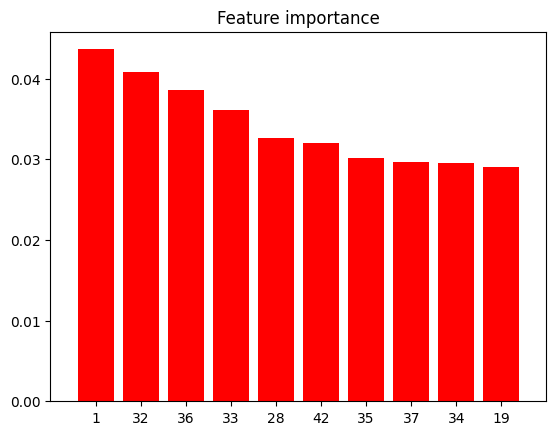

In [115]:
print("Best Validation Score: {}".format(grid_search.best_score_))
print("Best params: {}".format(grid_search.best_params_))
print("Random Forest test score :",grid_search.score(X_test,y_test))

best_RF = grid_search.best_estimator_
importances = best_RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Affiche le classement des features
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

In [116]:
test_data = pd.read_csv('features_test.csv')
X = test_data.drop(['ID'], axis=1)

Y_pred = grid_search.predict(X)
test_data['CLASS'] = Y_pred
new_submission = test_data[['ID', 'CLASS']]
new_submission.to_csv('new_submission.csv', index=False)

On observe que les features les plus importantes sont pourtants les plus basiques à savoir l'âge et les moyennes et variances dans les canaux R,G,B de l'image.
Les résultats semblent très bons puisque le score de précision est 96% avec 1000 arbres qui est la valeur donnée par l'article. 

Cepedant, on obtient réellement un résultat de 0.45 sur le challenge kaggle. Deux raisons peuvent expliquer l'envergure de cette différence, premièrement la métrique n'est pas bonne. En effet, on aimerait mettre en avant les erreurs sur les classes minoritaires même si l'on a suréchantillonné ces classes. 
On voit effectivement sur le dossier de submission que les classes 6,7 et 8 sont en très faibles quantités donc on a surement rater des prédictions sur celles-ci.

On peut estimer que notre oversampling étant sommaire, et pas très poussé, sans transformation, il soit toujours difficile de discerner ces classes.
Enfin, notre précision élevé est surement liée à de l'overfitting.

On va essayer de coder la méthode d'accuracy donné pour ce challenge en particulier pour avoir un résultat plus représentatif, et nous allons afficher la matrice de confusion pour savoir ce qui est bien prédit et ce qui l'est moins.


In [120]:
def weighted_accuracy(y_true, y_pred, weights):
    # Calculer un tableau de booléens indiquant si chaque prédiction est correcte
    correct_predictions = (y_true == y_pred)

    # Calculer l'accuracy pondérée
    return np.sum(weights * correct_predictions) / np.sum(weights)

# Supposons que y_test sont les vraies valeurs, y_pred sont les valeurs prédites
# et weights sont les poids pour chaque classe
weights = np.array([0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745])
weights = weights[y_test-1] 
print(weights[:10])
print(y_test[:10])

print('Weighted Accuracy:', weighted_accuracy(y_test, y_pred, weights))

[ 5.04219745  0.95261733  0.95261733  0.24592265 12.56547619  0.24592265
  0.7005531   5.04219745  3.64804147 12.56547619]
1389     8
11940    3
12724    3
75122    2
58501    7
75231    2
23788    1
5488     8
38924    4
61631    7
Name: CLASS, dtype: int64
Weighted Accuracy: 0.997555843508207


In [127]:
# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.96      0.94      1909
           2       0.96      0.87      0.91      1933
           3       0.94      0.99      0.96      1877
           4       1.00      1.00      1.00      1955
           5       0.97      0.99      0.98      1977
           6       1.00      1.00      1.00      1963
           7       1.00      1.00      1.00      1905
           8       1.00      1.00      1.00      1933

    accuracy                           0.97     15452
   macro avg       0.97      0.97      0.97     15452
weighted avg       0.97      0.97      0.97     15452



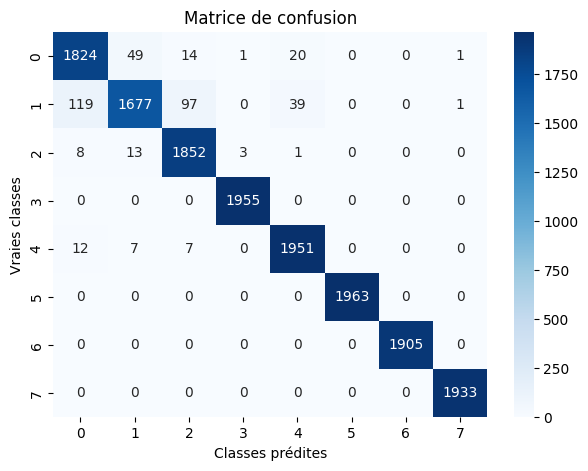

In [133]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')   
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

La matrice de confusion semble confirmer que les résultats sont bien prédits. En effet, on a ici 20% du dataset ce qui correspond à $\frac {77000} 8 \approx 15 000$ et qui sont bien réparti uniformément entre les différentes classes grâce aux suréchantillonages.
On en déduit donc que notre upsampling est surement en partie responsable de l'overfitting et que c'est l'overfitting qui est responsable de cette différence d'accuracy.

On va essayer de réduire la quantité d'arbre pour moins overfitter notre modèle est avoir une précision plus faible mais peut-être augmenter la précision sur les données tests

In [136]:
train_data = pd.read_csv('features_train.csv')
X = train_data.drop(['ID', 'CLASS'], axis=1)
y = train_data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

RF = RandomForestClassifier(n_estimators=300, min_samples_split=10, min_samples_leaf=5)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))


test_data = pd.read_csv('features_test.csv')
X_test = test_data.drop(['ID'], axis=1)

Y_pred = grid_search.predict(X_test)
test_data['CLASS'] = Y_pred
new_submission = test_data[['ID', 'CLASS']]
new_submission.to_csv('nouvelle_submission_RF.csv', index=False)

Accuracy: 0.9618819570282164


Même avec 300 arbres et des paramètres qui permettent de moins overfit, on a exactement les mêmes  résultats pour le private et public score sur le kaggle à 0.45 environ que précédemment, qu'avec d'autres features testés avant et qui ne sont pas reportées ici. 

Par ailleurs, la précision ne dépassant pas 0.5. On ne peut pas employer la technique adaboost pour améliorer le résultat de notre Random Forest. On va essayer en conséquence d'autres algorithmes.

In [7]:
train_data = pd.read_csv('features_train_not_upsampled.csv')
X = train_data.drop(['ID', 'CLASS'], axis=1)
y = train_data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


RF = make_pipeline2(ADASYN(random_state=0),StandardScaler(),RandomForestClassifier(n_estimators=500)) 
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

test_data = pd.read_csv('features_test.csv')
X_test = test_data.drop(['ID'], axis=1)

Y_pred = RF.predict(X_test)
test_data['CLASS'] = Y_pred
new_submission = test_data[['ID', 'CLASS']]
new_submission.to_csv('nouvelle_submission_RF_adasyn.csv', index=False)

Accuracy: 0.7207894736842105


Les résultats avec la pipeline en utilisant la fonction Adasyn pour upsample sont bien meilleur, avec un nombre d'arbre égale à 300 on a obtenu un score supérieur à 0.5 d'accuracy. L'accuracy semble augmenter quand on augmente le nombre d'arbre mais pour 500 arbres le taux de bonne réponse sur le kaggle reste le même. On peut donc confirmer notre hypothèse que la façon d'upsample était une des barrières à l'amélioration de notre classification. Bien évidemment, il est certain que notre segmentation ainsi que nos features pourrait être amélioré pour augmenter les résultats. 

On va tout de même tester un LinearSVC et Un K-plus proches voisins pour pouvoir comparer les résultats même si les papier semblent affirmer que le Random Forest donne les meilleurs résultats. 

---
#### **B.  Classification avec des SVM**
---

Avec ces algorithmes on n'utilisera que le dataset non suréchantillonné et avec adasyn.

In [8]:
train_data = pd.read_csv('features_train_not_upsampled.csv')
X = train_data.drop(['ID', 'CLASS'], axis=1)
y = train_data['CLASS']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fitting Non-linear SVM to the training set
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START linearsvc__C=0.1............................................
[CV 1/5; 1/3] END .............linearsvc__C=0.1;, score=0.372 total time=  15.8s
[CV 2/5; 1/3] START linearsvc__C=0.1............................................
[CV 2/5; 1/3] END .............linearsvc__C=0.1;, score=0.344 total time=  18.4s
[CV 3/5; 1/3] START linearsvc__C=0.1............................................
[CV 3/5; 1/3] END .............linearsvc__C=0.1;, score=0.344 total time=  16.4s
[CV 4/5; 1/3] START linearsvc__C=0.1............................................
[CV 4/5; 1/3] END .............linearsvc__C=0.1;, score=0.363 total time=  16.5s
[CV 5/5; 1/3] START linearsvc__C=0.1............................................
[CV 5/5; 1/3] END .............linearsvc__C=0.1;, score=0.338 total time=  16.1s
[CV 1/5; 2/3] START linearsvc__C=1..............................................
[CV 1/

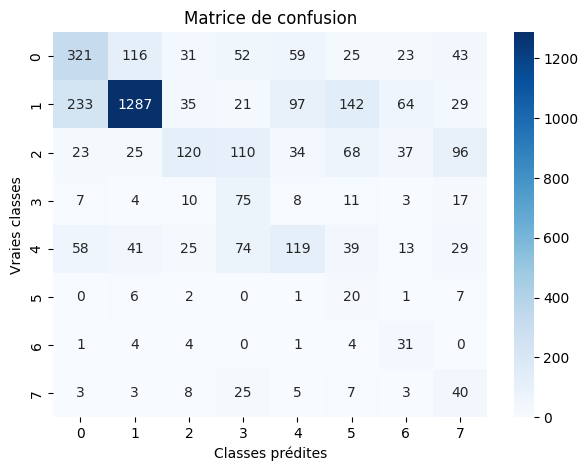

In [17]:
# Fitting linear SVM
print("Fitting linear SVM to the training set")

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC(max_iter = 1000, dual=False)) 

p_grid_lsvm = {'linearsvc__C': [1e-1,1,10]}

grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="f1_macro", cv=5, verbose = 10)
grid_lsvm.fit(X_train, y_train)

print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix  
plt.figure(figsize=(7, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')   
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

test_data = pd.read_csv('features_test.csv')
X_test = test_data.drop(['ID'], axis=1)

Y_pred = grid_lsvm.predict(X_test)
test_data['CLASS'] = Y_pred
new_submission = test_data[['ID', 'CLASS']]
new_submission.to_csv('nouvelle_submission_lsvm.csv', index=False)

On a eu avec ce simple kernel linéaire une accuracy de 0.3 mais tout de même 45% de bonnes réponses sur les données tests.
On va réessayer avec un kernel non linéaire.

Fitting linear SVM to the training set
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START svc__gamma=0.01.............................................
[CV 1/5; 1/2] END ..............svc__gamma=0.01;, score=0.496 total time= 1.6min
[CV 2/5; 1/2] START svc__gamma=0.01.............................................
[CV 2/5; 1/2] END ..............svc__gamma=0.01;, score=0.475 total time= 1.7min
[CV 3/5; 1/2] START svc__gamma=0.01.............................................
[CV 3/5; 1/2] END ..............svc__gamma=0.01;, score=0.499 total time= 1.6min
[CV 4/5; 1/2] START svc__gamma=0.01.............................................
[CV 4/5; 1/2] END ..............svc__gamma=0.01;, score=0.492 total time= 1.6min
[CV 5/5; 1/2] START svc__gamma=0.01.............................................
[CV 5/5; 1/2] END ..............svc__gamma=0.01;, score=0.476 total time= 1.6min
[CV 1/5; 2/2] START svc__gamma=0.1..............................................


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 2/2] END ...............svc__gamma=0.1;, score=0.499 total time= 2.0min
[CV 2/5; 2/2] START svc__gamma=0.1..............................................


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 2/2] END ...............svc__gamma=0.1;, score=0.510 total time= 2.1min
[CV 3/5; 2/2] START svc__gamma=0.1..............................................


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 2/2] END ...............svc__gamma=0.1;, score=0.501 total time= 2.4min
[CV 4/5; 2/2] START svc__gamma=0.1..............................................


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 2/2] END ...............svc__gamma=0.1;, score=0.497 total time= 2.0min
[CV 5/5; 2/2] START svc__gamma=0.1..............................................


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 2/2] END ...............svc__gamma=0.1;, score=0.496 total time= 1.9min


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best training Score: 0.5005561316767262
Best training params: {'svc__gamma': 0.1}


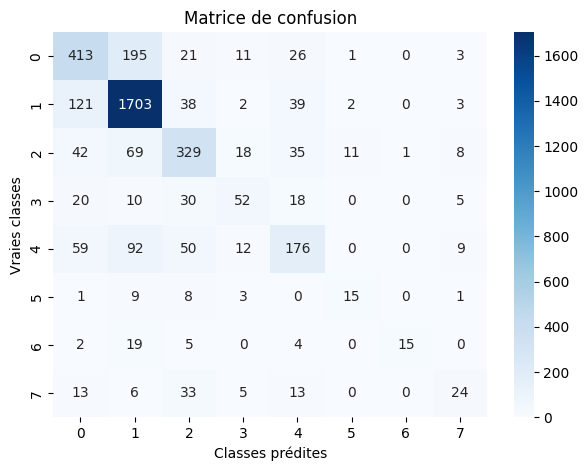

In [25]:
# Fitting linear SVM
print("Fitting linear SVM to the training set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nlsvm_pipeline = make_pipeline2(ADASYN(random_state=0), StandardScaler(), SVC(kernel='rbf', C=1, max_iter=10000))

# Grille de recherche pour le SVM avec noyau RBF
p_grid_nlsvm = {
    'svc__gamma': [0.01, 0.1]
}

# GridSearchCV pour optimiser les hyperparamètres
grid_nlsvm = GridSearchCV(estimator=nlsvm_pipeline, param_grid=p_grid_nlsvm, scoring="f1_macro", cv=5, verbose=10)
grid_nlsvm.fit(X_train, y_train)

print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

# Prédiction et évaluation
y_pred = grid_nlsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(7, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

# Chargement et prédiction des données de test
test_data = pd.read_csv('features_test.csv')
X_test = test_data.drop(['ID'], axis=1)
Y_pred = grid_nlsvm.predict(X_test)
test_data['CLASS'] = Y_pred
new_submission = test_data[['ID', 'CLASS']]
new_submission.to_csv('nouvelle_submission_nlsvm.csv', index=False)


Les résultats entre le SVM non linéaire et linéaire sont assez similaires et en deça en terme de résultat au Random Forest.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START kneighborsclassifier__n_neighbors=1.........................


[CV 1/5; 1/5] END kneighborsclassifier__n_neighbors=1;, score=0.496 total time=   2.3s
[CV 2/5; 1/5] START kneighborsclassifier__n_neighbors=1.........................
[CV 2/5; 1/5] END kneighborsclassifier__n_neighbors=1;, score=0.514 total time=   1.9s
[CV 3/5; 1/5] START kneighborsclassifier__n_neighbors=1.........................
[CV 3/5; 1/5] END kneighborsclassifier__n_neighbors=1;, score=0.506 total time=   1.6s
[CV 4/5; 1/5] START kneighborsclassifier__n_neighbors=1.........................
[CV 4/5; 1/5] END kneighborsclassifier__n_neighbors=1;, score=0.488 total time=   1.6s
[CV 5/5; 1/5] START kneighborsclassifier__n_neighbors=1.........................
[CV 5/5; 1/5] END kneighborsclassifier__n_neighbors=1;, score=0.496 total time=   1.5s
[CV 1/5; 2/5] START kneighborsclassifier__n_neighbors=2.........................
[CV 1/5; 2/5] END kneighborsclassifier__n_neighbors=2;, score=0.493 total time=   1.5s
[CV 2/5; 2/5] START kneighborsclassifier__n_neighbors=2..................

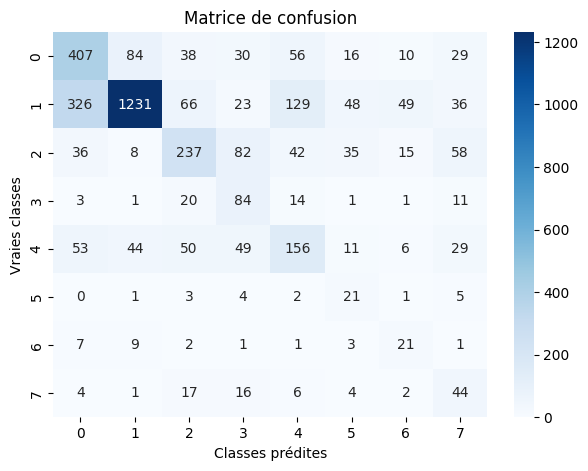

In [21]:
# Looking for the best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,4,8,10]}

KNN = make_pipeline2(ADASYN(random_state=0),StandardScaler(), KNeighborsClassifier()) 
grid_KNN = GridSearchCV(estimator=KNN , param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5, verbose=10)
grid_KNN.fit(X_train, y_train)


print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')   
plt.ylabel('Vraies classes')
plt.xlabel('Classes prédites')
plt.show()

test_data = pd.read_csv('features_test.csv')
X_test = test_data.drop(['ID'], axis=1)

Y_pred = grid_KNN.predict(X_test)
test_data['CLASS'] = Y_pred
new_submission = test_data[['ID', 'CLASS']]
new_submission.to_csv('nouvelle_submission_KNN.csv', index=False)


Malgré un score de 0.521, on a eu pour l'instant le meilleur score, avec une accuracy de 0.538. Cela laisse à penser que notre algorithme de Random Forest overfit beaucoup alors qu'au contraire les derniers algorithmes présentaient ici quant à eux underfit. 

**En conclusion, les meilleurs résultats sont obtenus avec le Random Forest et le Kmean, comme les articles tendent à affirmer que le Random Forest et l'algorithme qui fonctionne le mieux, on peut supposer que certaines méthodes non évoqué ici permettent de l'améliorer.**

---
## <center> **Partie V: Utilisation d'un CNN pour la classification**<center>

Enfin, la dernière méthode que j'ai tenté d'appliquer et un réseau de neurones de convolutions puisque leur supériorité sur les algorithmes usuelles a été prouvées les denières années. Pour cela, on va prétraitées les images et les redimmensionner pour qu'elles aient la même taille ce qui est nécessaire pour un réseau de neurones


On importe les librairies

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import cv2

from tqdm import tqdm
import os

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt
import PIL

import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

On va appliquer dullrazor pour améliorer les images et puis les resize pour qu'elles aient toute la même taille et qu'on puisse les faire passer dans le CNN.

In [ ]:
def dullrazor(image):
    img = cv2.imread(image, cv2.IMREAD_COLOR)
    grayScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

    return dst


def save_img(images, output_dir):

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process and save each image and its corresponding mask
    for i in tqdm(range(len(images))):
        
        # Preprocess the image and the mask
        original_image_name = images[i].split('/')[-1].split('.')[0]
        original_image_name = original_image_name.split('\\')[-1]

        ## remove hair
        preprocessed_image = dullrazor(images[i])
        preprocessed_image = (preprocessed_image ).astype('uint8')

        #convert en bgr
        preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_RGB2BGR)
        # Write the preprocessed image and mask to the output directory
        cv2.imwrite(os.path.join(output_dir, f'{original_image_name}.jpg'), preprocessed_image)

In [ ]:
# Dossier source
src_dir_train = 'preprocessed_images_train_for_cnn'


dst_dir_train = os.path.join(os.getcwd(), 'resized_train')
os.makedirs(dst_dir_train, exist_ok=True)

# Parcourir les fichiers dans le dossier source
for filename in tqdm(os.listdir(src_dir_train)):
    if filename.endswith('.jpg'):  
        # Ouvrir l'image
        img = Image.open(os.path.join(src_dir_train, filename))
        
        # Redimensionner l'image
        img_resized = img.resize((128, 128))
        
        # Enregistrer l'image redimensionnée dans le dossier de destination
        img_resized.save(os.path.join(dst_dir_train, filename))


# Dossier source
src_dir_train = 'preprocessed_images_test_for_cnn'

# Dossier de destination
dst_dir_train = os.path.join(os.getcwd(), 'resized_test')
os.makedirs(dst_dir_train, exist_ok=True)

# Parcourir les fichiers dans le dossier source
for filename in tqdm(os.listdir(src_dir_train)):
    if filename.endswith('.jpg'):  
        # Ouvrir l'image
        img = Image.open(os.path.join(src_dir_train, filename))
        
        # Redimensionner l'image
        img_resized = img.resize((128, 128))
        
        # Enregistrer l'image redimensionnée dans le dossier de destination
        img_resized.save(os.path.join(dst_dir_train, filename))

In [ ]:
# utilise les informations ID et CLASS des métadonnées pour séparer les images dans leur différentes classes
import pandas as pd
import shutil

metadata = pd.read_csv('metadataTrain.csv')

# Créer un dossier pour chaque classe
classes = metadata['CLASS'].unique()
for class_name in classes:
    os.makedirs(os.path.join('resized_train', str(class_name)), exist_ok=True)

# Déplacer chaque image dans le dossier de sa classe
for index, row in tqdm(metadata.iterrows()):
    image_name = row['ID'] + '.jpg'
    class_name = str(row['CLASS'])
    shutil.move(os.path.join('resized_train', image_name), os.path.join('resized_train', class_name, image_name))

In [ ]:
# Convert input to Pytorch tensors
input_transform=transforms.Compose([transforms.ToTensor()])

dataset = datasets.ImageFolder('resized_train', transform=input_transform)


train_size = int(0.8 * len(dataset))  # 80% des données pour l'entraînement
test_size = len(dataset) - train_size  # 20% des données pour le test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loader with smaller dataset size
max_train_size = 5000
train_dataset_reduced = torch.utils.data.random_split(train_dataset, [max_train_size, len(train_dataset)-max_train_size])[0]

X_train = torch.stack([x[0] for x in train_dataset_reduced])
Y_train = torch.tensor([x[1]+1 for x in train_dataset_reduced], dtype=torch.uint8)

# Préparer les données de test
X_test = torch.stack([x[0] for x in test_dataset])
Y_test = torch.tensor([x[1] for x in test_dataset], dtype=torch.uint8)

nb_channels = X_train.shape[1]

In [ ]:
to_pil = transforms.ToPILImage()
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Créer une figure avec 5 sous-graphiques
for i in range(5):  # Afficher les 5 premières images
    axs[i].imshow(to_pil(X_train[i]))
    axs[i].set_title(f'Class: {Y_train[i]}')
    axs[i].axis('off')
plt.show()

In [ ]:
learning_rate = 0.01
n_epochs = 10
batch_size = 64
nb_classes = 8

vgg_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
vgg_train_loader = torch.utils.data.DataLoader(train_dataset_reduced, batch_size=batch_size, shuffle=True)
criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(vgg_model.parameters(), lr= learning_rate)

In [ ]:
def vector_to_class(x):
  y = torch.argmax(nn.Softmax(dim=1)(x),axis=1)
  return y

def cnn_accuracy(predict,labels,class_weights):
        # Convertir les prédictions et les étiquettes en tableaux numpy
    predict = predict.numpy()
    labels = labels.numpy()

    # Créer un tableau de poids pour chaque échantillon
    sample_weights = class_weights[labels]

    # Calculer la précision pondérée
    correct_predictions = (predict == labels)
    weighted_accuracy = (correct_predictions * sample_weights).sum() / sample_weights.sum()

    return weighted_accuracy

class_weights = [ 0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

In [ ]:
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in tqdm(enumerate(vgg_train_loader)):
    # pass the samples through the network
    predict = vgg_model(imgs) 
    # apply loss function
    loss = criterion(predict, labels) 
    # set the gradients back to 0
    optimizer.zero_grad()
    # backpropagation
    loss.backward() 
    # parameter update
    optimizer.step() 
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())
    print(f'Epoch: {epoch} Batch: {batch_idx+1}/{len(vgg_train_loader)}')

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(vgg_train_loader)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels), class_weights)))

In [ ]:
predict_train = vgg_model(X_train)
predict_test = vgg_model(X_test)

train_accuracy = cnn_accuracy(np.array(vector_to_class(predict_train)), np.array(Y_train), class_weights)
test_accuracy = cnn_accuracy(np.array(vector_to_class(predict_test)), np.array(Y_test), class_weights)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

In [ ]:
test_dataset = datasets.ImageFolder('resized_test', transform=input_transform)

# Préparer les données de test
X_test = torch.stack([x[0] for x in test_dataset])

# Passer les images de test à travers le modèle
predict_test = vgg_model(X_test)

# Convertir les prédictions en classes
predicted_classes = vector_to_class(predict_test)

# Obtenir les noms des images
image_names = [x[0].split('/')[-1] for x, _ in test_dataset.imgs]

# Créer un DataFrame avec les noms des images et les classes prédites
df = pd.DataFrame({
    'Image': image_names,
    'Class': predicted_classes
})

# Enregistrer le DataFrame en tant que fichier CSV
df.to_csv('predictions.csv', index=False)

J'ai suivi la méthode employé lors de TP en essayant de réutiliser l'architecture VGG utilisé pour la classification d'objet cependant, j'ai eu beaucoup de mal à utiliser les GPU et même en changeant le modèle j'ai eu des problèmes de mémoire sur le GPU et de système avec pytorch ou une autre méthode que j'avais implémenté à l'aide de tensorflow et je n'ai donc pas de résultat à montrer pour cette partie. 